### **2.2 SQL Analysis**

---

#### **Objectives**

Demonstrate advanced SQL skills by creating a database-driven analysis workflow and answering complex business questions through structured queries.

---

In [44]:
import psycopg2
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from typing import List
import matplotlib as mpl
from typing import Optional
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from abc import ABC, abstractmethod
from psycopg2.extras import execute_values

In [ ]:
class DataSqlIntegration(ABC):
      """
      Abstract base class for bank marketing data SQL integration operations.

      This class defines the interface for loading bank marketing data into a SQL database
      and querying results. Concrete implementations must provide the actual database
      interaction logic.

      Attributes:
            dataPath (str): Path to the data file to be processed
      """
      def __init__(self, dataPath: str) -> None:
            """
            Initialize the data integration handler.
            
            Args:
            dataPath: Path to the bank marketing data file
            """
            self.dataPath = dataPath

      @abstractmethod
      def createTable(self, connection: psycopg2.connect) -> None:
            """
            Create the bank_marketing table in the database.
            
            Args:
            connection: Active PostgreSQL database connection
            
            Raises:
            psycopg2.Error: If table creation fails
            """
            pass

      @abstractmethod
      def answerQueryAnswer(self, connection:psycopg2.connect, queryString: str, index: List[str]) -> pd.DataFrame:
            """
            Convert SQL query results into a pandas DataFrame.
            
            Args:
            queryRows: List of tuples from SQL query results
            index: List of index values for the DataFrame
            
            Returns:
            pd.DataFrame: Formatted DataFrame from query results
            """
            pass

      @abstractmethod
      def insertRecordsIntoTable(self, connection: psycopg2.connect, alreadyAdded: bool, batch_size: int = 100_000) -> None:
            """
            Insert records from the data file into the database table.

            Args:
            connection: Active PostgreSQL database connection

            Raises:
            psycopg2.Error: If data insertion fails
            """
            pass


class EcommerceDataSqlIntegration(DataSqlIntegration):
      """
      Concrete implementation of bank marketing data SQL integration.
      
      Provides PostgreSQL-specific implementation for loading bank marketing campaign data
      and converting query results to pandas DataFrames.
      """
      
      def createTable(self, connection: psycopg2.connect) -> None:
            """
            Create the ecommerce_events table with proper schema if it doesn't exist.
            """
            cursor = connection.cursor()
            try:
                  cursor.execute("""
                        CREATE TABLE IF NOT EXISTS ecommerce_events (
                        event_id BIGSERIAL PRIMARY KEY,
                        event_time TIMESTAMPTZ NOT NULL,
                        event_type VARCHAR(20) NOT NULL CHECK (event_type IN ('view', 'cart', 'purchase')),
                        product_id BIGINT,
                        category_id BIGINT,
                        brand TEXT,
                        price NUMERIC(12,2),
                        user_id BIGINT,
                        user_session TEXT,

                        isFreeItem BOOLEAN,
                        isLuxuryItem BOOLEAN,
                        isExtremeOutlier BOOLEAN,
                        isAbnormal BOOLEAN,
                        has_purchase BOOLEAN,
                        isMultiDaySession BOOLEAN,
                        hasCategoryCode BOOLEAN,

                        category_l1 TEXT,
                        category_l2 TEXT,
                        category_l3 TEXT,
                        isLowFrequencyCategory BOOLEAN,

                        sessionDuration REAL,
                        sessionStartHour SMALLINT,
                        sessionDayOfWeek TEXT,
                        isWeekendSession BOOLEAN,
                        isMidnightActivity BOOLEAN,
                        isDirectPurchase BOOLEAN,
                        isDirectPurchase_right BOOLEAN,
                        isAbandonedCart BOOLEAN,
                        advancedToCart BOOLEAN,
                        advancedToPurchase BOOLEAN,
                        EngagementDepth INTEGER,

                        popularityScore REAL,
                        categoryConversionRate REAL,
                        isInMultiCategories BOOLEAN
                        );
                  """)
                  connection.commit()
            except psycopg2.Error as e:
                  connection.rollback()
                  raise e

      def addTableIndexes(self, connection: psycopg2.connect) -> None:
            try:
                  cursor = connection.cursor()
                  cursor.execute("CREATE INDEX IF NOT EXISTS idx_user_id ON ecommerce_events(user_id);")
                  cursor.execute("CREATE INDEX IF NOT EXISTS idx_product_id ON ecommerce_events(product_id);")
                  cursor.execute("CREATE INDEX IF NOT EXISTS idx_event_type ON ecommerce_events(event_type);")
                  cursor.execute("CREATE INDEX IF NOT EXISTS idx_event_time_brin ON ecommerce_events USING BRIN(event_time);")
                  cursor.execute("CREATE INDEX IF NOT EXISTS idx_user_event_time ON ecommerce_events(user_id, event_time);")
                  cursor.execute("CREATE INDEX IF NOT EXISTS idx_product_event_type ON ecommerce_events(product_id, event_type);")
                  cursor.execute("CREATE INDEX IF NOT EXISTS idx_purchase_only ON ecommerce_events(product_id, event_time) WHERE event_type = 'purchase';")
                  cursor.execute("ANALYZE ecommerce_events;")
                  connection.commit()

            except psycopg2.Error as e:
                  connection.rollback()
            
            finally:
                  cursor.close()

      def insertRecordsIntoTable(self, connection: psycopg2.connect, alreadyAdded: bool, batchSize: int = 100_000):
            if alreadyAdded:
                  return

            try:
                  cursor = connection.cursor()

                  # Lazy read Parquet
                  lazy_df = pl.scan_parquet(self.dataPath)
                  df = lazy_df.collect()
                  total_rows = df.height

                  # Iterate in chunks with progress bar
                  for start in tqdm(range(0, total_rows, batchSize), desc="Inserting rows"):
                        end = min(start + batchSize, total_rows)
                        chunk = df[start:end]
                        data_tuples = [tuple(row) for row in chunk.to_numpy()]

                        if data_tuples:
                              execute_values(cursor, """
                                    INSERT INTO ecommerce_events (
                                          event_time, event_type, product_id, category_id, brand, price, user_id, user_session,
                                          isFreeItem, isLuxuryItem, isExtremeOutlier, isAbnormal, has_purchase, isMultiDaySession,
                                          hasCategoryCode,
                                          category_l1, category_l2, category_l3,
                                          isLowFrequencyCategory,
                                          sessionDuration, sessionStartHour, sessionDayOfWeek, isWeekendSession,
                                          isMidnightActivity, isDirectPurchase, isDirectPurchase_right,
                                          isAbandonedCart, advancedToCart, advancedToPurchase, EngagementDepth,
                                          popularityScore, categoryConversionRate,
                                          isInMultiCategories
                                    ) VALUES %s
                              """, data_tuples)
                              connection.commit()

            except Exception as e:
                  connection.rollback()
                  raise e

      def addSummaryTables(self, connection: psycopg2.connect) -> None:
            try:
                  cursor = connection.cursor()
                  cursor.execute("""
                        CREATE MATERIALIZED VIEW IF NOT EXISTS daily_revenue_summary AS
                        SELECT
                        DATE(event_time) AS event_date,
                        SUM(price) AS total_revenue,
                        COUNT(*) FILTER (WHERE event_type = 'purchase') AS total_purchases
                        FROM ecommerce_events
                        WHERE event_type = 'purchase'
                        GROUP BY DATE(event_time)
                        ORDER BY event_date;
                  """)
                  cursor.execute("""
                        CREATE MATERIALIZED VIEW IF NOT EXISTS product_perf_summary AS
                        SELECT
                        product_id,
                        COUNT(*) FILTER (WHERE event_type = 'view') AS total_views,
                        COUNT(*) FILTER (WHERE event_type = 'cart') AS total_cart,
                        COUNT(*) FILTER (WHERE event_type = 'purchase') AS total_purchases,
                        (COUNT(*) FILTER (WHERE event_type = 'purchase')::decimal 
                        / NULLIF(COUNT(*) FILTER (WHERE event_type = 'view'), 0)) AS conversion_rate
                        FROM ecommerce_events
                        GROUP BY product_id
                        ORDER BY conversion_rate DESC;
                  """)
                  cursor.execute("""
                        CREATE MATERIALIZED VIEW IF NOT EXISTS customer_rfm AS
                        SELECT
                        user_id,
                        DATE_PART('day', CURRENT_DATE - MAX(event_time) FILTER (WHERE event_type = 'purchase')) AS recency,
                        COUNT(*) FILTER (WHERE event_type = 'purchase') AS frequency,
                        COALESCE(SUM(price) FILTER (WHERE event_type = 'purchase'), 0) AS monetary
                        FROM
                        ecommerce_events
                        GROUP BY
                        user_id
                        ORDER BY
                        monetary DESC;
                  """)
                  connection.commit()

            except psycopg2.Error as e:
                  connection.rollback()
            
            finally:
                  cursor.close() 

      def answerQueryAnswer(self, connection: psycopg2.connect, queryString: str) -> pl.DataFrame:
            cursor = connection.cursor()
            try:
                  cursor.execute(queryString)
                  queryRows = cursor.fetchall()

                  print(f"Query returned {len(queryRows)} rows")
                  if queryRows:
                        print("First row sample:", queryRows[0])

                  if not queryRows:
                        return pl.DataFrame()  # empty Polars DataFrame

                  col_names = [desc[0] for desc in cursor.description]
                  df = pl.DataFrame(queryRows, schema=col_names)

                  return df

            except psycopg2.Error as e:
                  print(f"Database error: {e}")
                  return pl.DataFrame()

            finally:
                  cursor.close()



In [3]:
dataSqlIntegration = EcommerceDataSqlIntegration(dataPath="D:\programming\Data Analysis\E-commerceCustomerBehaviorAnalysis\Data\Processed\prsc_fe9_nov_2019.parquet")
connection = psycopg2.connect(database="ecommerceCustomers",host="localhost",user="postgres",
                                    password="postgres",port="5432")

In [76]:
class QueryVisualizer:
    def __init__(self, df):
        """
        Initialize with a Polars or Pandas DataFrame from your SQL query.
        Expects columns like ['user_id', 'category_l1', 'clv', 'rank_within_category'],
        but works for any structure depending on the visualization method.
        """
        # Convert Polars -> Pandas if needed
        if isinstance(df, pl.DataFrame):
            self.df = df.to_pandas()
        elif isinstance(df, pd.DataFrame):
            self.df = df.copy()  # make a safe copy
        else:
            raise TypeError("df must be a Polars or Pandas DataFrame")

        # Ensure clv column is numeric float if it exists
        if "clv" in self.df.columns:
            self.df["clv"] = pd.to_numeric(self.df["clv"], errors="coerce")
            
    def plotTopCustomersBar(
        self,
        topN: int = 10,
        figSize: tuple = (12, 6),
        cmap: str = "tab20",   # use categorical colormap
        sortByClv: bool = True,
        ascending: bool = False,
    ):
        """
        Horizontal bar chart of top N customers by CLV.
        Bars colored by category with matching legend.
        """
        # Filter
        if "rank_within_category" in self.df.columns:
            topDf = self.df[self.df["rank_within_category"] <= topN].copy()
        else:
            topDf = self.df.nlargest(topN, "clv").copy()

        # Ensure types
        topDf["user_id"] = topDf["user_id"].astype(str)

        # Sorting
        if sortByClv:
            topDf = topDf.sort_values("clv", ascending=ascending).reset_index(drop=True)

        # Assign category colors
        categories = topDf["category_l1"].unique()
        cmapObj = plt.get_cmap(cmap, len(categories))
        colorMap = {cat: cmapObj(i) for i, cat in enumerate(categories)}

        # Map category to color
        colors = topDf["category_l1"].map(colorMap)

        # Plot
        fig, ax = plt.subplots(figsize=figSize)
        bars = ax.barh(
            range(len(topDf)),
            topDf["clv"],
            color=colors,
            height=0.7
        )

        if sortByClv and not ascending:
            ax.invert_yaxis()

        ax.set_yticks([])
        ax.set_ylabel("")
        ax.set_xlabel("Customer Lifetime Value (CLV)", fontsize=12)
        ax.set_title(f"Top {topN} Customers by CLV", fontsize=14, fontweight="bold")

        # Legend
        legendHandles = [
            plt.Line2D([0], [0], marker="s", color="w",
                    markerfacecolor=colorMap[cat], markersize=10, label=cat)
            for cat in categories
        ]
        ax.legend(handles=legendHandles, title="Categories", loc="best")

        plt.tight_layout()
        plt.show()
    
    def plotLongestPurchaseGapBar(self, topN=20, figSize=(12,6), cmap="plasma", timeUnit="days"):
            """
            Horizontal bar chart showing top N users with longest gaps between purchases.
            timeUnit: 'days', 'hours', or 'seconds' — converts Timedelta to numeric
            """
            df = self.df.sort_values("gap", ascending=False).head(topN).copy()
            df["user_id"] = df["user_id"].astype(str)

            # Convert Timedelta to numeric
            if np.issubdtype(df["gap"].dtype, np.timedelta64):
                if timeUnit == "days":
                    df["gap_numeric"] = df["gap"].dt.total_seconds() / 86400
                elif timeUnit == "hours":
                    df["gap_numeric"] = df["gap"].dt.total_seconds() / 3600
                elif timeUnit == "seconds":
                    df["gap_numeric"] = df["gap"].dt.total_seconds()
                else:
                    raise ValueError("timeUnit must be 'days', 'hours', or 'seconds'")
            else:
                df["gap_numeric"] = df["gap"].astype(float)

            norm = plt.Normalize(df["gap_numeric"].min(), df["gap_numeric"].max())
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

            fig, ax = plt.subplots(figsize=figSize)
            bars = ax.barh(
                df["user_id"],
                df["gap_numeric"],
                color=sm.to_rgba(df["gap_numeric"].values),
                height=0.7
            )
            ax.invert_yaxis()  # largest gap at top

            ax.set_xlabel(f"Gap Between Purchases ({timeUnit})")
            ax.set_yticks([])
            ax.set_ylabel("User ID")
            ax.set_title(f"Top {topN} Users by Longest Purchase Gap", fontsize=14, fontweight="bold")

            # Colorbar
            cbar = fig.colorbar(sm, ax=ax)
            cbar.set_label(f"Gap ({timeUnit})")

            plt.tight_layout()
            plt.show()

    def plotPurchaseGapDistribution(self, figSize=(12,6), bins=50, timeUnit="days", cmap="viridis"):
        """
        Histogram showing distribution of purchase gaps across all users.
        Bars colored by gap value (value -> color).
        timeUnit: 'days', 'hours', 'seconds'
        """
        df = self.df.copy()

        # Convert gap to numeric
        if np.issubdtype(df["gap"].dtype, np.timedelta64):
            if timeUnit == "days":
                df["gap_numeric"] = df["gap"].dt.total_seconds() / 86400
            elif timeUnit == "hours":
                df["gap_numeric"] = df["gap"].dt.total_seconds() / 3600
            elif timeUnit == "seconds":
                df["gap_numeric"] = df["gap"].dt.total_seconds()
            else:
                raise ValueError("timeUnit must be 'days', 'hours', or 'seconds'")
        else:
            df["gap_numeric"] = df["gap"].astype(float)

        # Compute histogram manually
        counts, bin_edges = np.histogram(df["gap_numeric"], bins=bins)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Normalize for colormap
        norm = plt.Normalize(df["gap_numeric"].min(), df["gap_numeric"].max())
        cmapObj = plt.get_cmap(cmap)
        colors = cmapObj(norm(bin_centers))

        # Plot
        fig, ax = plt.subplots(figsize=figSize)
        ax.bar(bin_centers, counts, width=(bin_edges[1]-bin_edges[0]), color=colors, edgecolor="black")

        # Labels
        ax.set_xlabel(f"Gap Between Purchases ({timeUnit})")
        ax.set_ylabel("Number of Users")
        ax.set_title("Distribution of Customer Purchase Gaps", fontsize=14, fontweight="bold")

        # Colorbar
        sm = plt.cm.ScalarMappable(cmap=cmapObj, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(f"Gap ({timeUnit})")

        plt.tight_layout()
        plt.show()
    
    def plotRollingActiveUsers(self, figSize=(12,6), cmap="viridis"):
        """
        Line chart of rolling 30-day active users over time.
        Colors line by value.
        """
        df = self.df.copy()
        df["day"] = pd.to_datetime(df["day"])
        df["rolling_30d_active_users"] = pd.to_numeric(df["rolling_30d_active_users"], errors="coerce")
        df = df.dropna(subset=["rolling_30d_active_users"])

        # Normalize values for color
        norm = plt.Normalize(df["rolling_30d_active_users"].min(), df["rolling_30d_active_users"].max())
        cmapObj = plt.get_cmap(cmap)

        import matplotlib.collections as mcoll
        import numpy as np

        x = mdates.date2num(df["day"])  # convert to matplotlib date numbers
        y = df["rolling_30d_active_users"].values.astype(float)

        points = np.array([x, y]).T.reshape(-1,1,2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = mcoll.LineCollection(segments, cmap=cmapObj, norm=norm)
        lc.set_array(y)
        lc.set_linewidth(2)

        fig, ax = plt.subplots(figsize=figSize)
        ax.add_collection(lc)
        ax.autoscale()

        # Format x-axis as dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        fig.autofmt_xdate(rotation=45)

        ax.set_xlabel("Date")
        ax.set_ylabel("30-day Rolling Active Users")
        ax.set_title("Rolling 30-Day Active Users Over Time", fontsize=14, fontweight="bold")

        # Colorbar
        cbar = fig.colorbar(lc, ax=ax)
        cbar.set_label("Active Users")

        plt.tight_layout()
        plt.show()

    def plotProductConversionRate(self, topN=50, figSize=(12,6), cmap="viridis", sortDescending=True):
        """
        Horizontal bar chart of top-N products by conversion rate.
        Colors bars based on conversion rate value.
        """
        df = self.df.copy()
        df["conversion_rate"] = pd.to_numeric(df["conversion_rate"], errors="coerce")
        df = df.dropna(subset=["conversion_rate"])

        # Sort top N
        if sortDescending:
            df = df.sort_values("conversion_rate", ascending=False).head(topN)
        else:
            df = df.sort_values("conversion_rate", ascending=True).head(topN)

        # Normalize colors
        norm = plt.Normalize(df["conversion_rate"].min(), df["conversion_rate"].max())
        cmapObj = plt.get_cmap(cmap)
        colors = cmapObj(norm(df["conversion_rate"].values))

        # Plot
        fig, ax = plt.subplots(figsize=figSize)
        ax.barh(df["product_id"].astype(str), df["conversion_rate"], color=colors)
        ax.invert_yaxis()
        ax.set_xlabel("Conversion Rate")
        ax.set_ylabel("Product ID")
        ax.set_title(f"Top {topN} Products by Conversion Rate", fontsize=14, fontweight="bold")

        # Colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label("Conversion Rate")

        plt.tight_layout()
        plt.show()

    def plotConversionHistogram(self, col="conversion_rate", bins=50, figSize=(10,6), cmap="viridis"):
        """
        Memory-safe histogram of conversion rates or any numeric metric.
        Bars colored by bin center value.
        """
        df = self.df.copy()

        # Ensure numeric float
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df = df.dropna(subset=[col])

        # Safety check for empty dataframe
        if df.empty:
            print(f"No numeric data found for column '{col}'. Cannot plot histogram.")
            return

        # Compute histogram
        counts, bin_edges = np.histogram(df[col], bins=bins)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Map colors
        vmin, vmax = bin_centers.min(), bin_centers.max()
        if vmin == vmax:
            vmax = vmin + 1e-6
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmapObj = plt.get_cmap(cmap)
        colors = cmapObj(norm(bin_centers))

        # Plot histogram
        fig, ax = plt.subplots(figsize=figSize)
        ax.bar(bin_centers, counts, width=(bin_edges[1]-bin_edges[0]), color=colors, edgecolor="black")
        ax.set_xlabel(col.replace("_"," ").title())
        ax.set_ylabel("Count")
        ax.set_title(f"Distribution of {col.replace('_',' ').title()}", fontsize=14, fontweight="bold")

        # Colorbar
        sm = mpl.cm.ScalarMappable(cmap=cmapObj, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(col.replace("_"," ").title())

        plt.tight_layout()
        plt.show()

    def plotHourlySessionsComparison(self,purchaseCol='purchase',viewCol='view',figSize=(12,6),cmap='tab10'):
        """
        Overlayed line chart comparing hourly sessions for purchases vs views.

        Assumes self.df contains columns:
            - sessionStartHour
            - purchaseSessionCount (optional)
            - viewSessionCount (optional)

        If self.df contains only one type, it will plot that alone.
        """
        df = self.df.copy()

        # Ensure sessionStartHour is sorted
        df = df.sort_values('sessionstarthour')

        fig, ax = plt.subplots(figsize=figSize)
        colors = plt.get_cmap(cmap)

        # Plot purchase sessions if column exists
        if 'purchasesessioncount' in df.columns:
            ax.plot(df['sessionstarthour'], df['purchasesessioncount'], 
                    label='Purchases', color=colors(0), marker='o')
        elif purchaseCol in df.columns:
            ax.plot(df['sessionstarthour'], df[purchaseCol], 
                    label='Purchases', color=colors(0), marker='o')

        # Plot view sessions if column exists
        if 'viewsessioncount' in df.columns:
            ax.plot(df['sessionstarthour'], df['viewsessioncount'], 
                    label='Views', color=colors(1), marker='o')
        elif viewCol in df.columns:
            ax.plot(df['sessionstarthour'], df[viewCol], 
                    label='Views', color=colors(1), marker='o')

        ax.set_xlabel("Hour of Day", fontsize=12)
        ax.set_ylabel("Number of Sessions", fontsize=12)
        ax.set_title("Hourly Sessions: Purchases vs Views", fontsize=14, fontweight="bold")
        ax.legend()
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plotHourlySessionsComparisonV2(self, cmap="viridis", figSize=(12,8)):
    

        df = self.df.copy()
        df["conversion_rate_per_day"] = df["conversion_rate_per_day"].astype(float)
        x = df["sessionstarthour"]

        fig = plt.figure(figsize=figSize)

        # Main axes (leave space on right for colorbar)
        ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.75])  # [left, bottom, width, height]

        # Line plots for purchase and view shares
        ax1.plot(x, df["purchase_share"], label="Purchase Share", color="tab:blue", linewidth=2)
        ax1.plot(x, df["view_share"], label="View Share", color="tab:orange", linewidth=2)
        ax1.set_xlabel("Session Start Hour")
        ax1.set_ylabel("Share")
        ax1.grid(True, alpha=0.3)
        plt.title("Hourly Purchase & View Sessions with Conversion Rate", fontsize=14, fontweight="bold")

        # Scatter for conversion rate
        ax2 = ax1.twinx()
        norm = mpl.colors.Normalize(df["conversion_rate_per_day"].min(), df["conversion_rate_per_day"].max())
        cmapObj = plt.get_cmap(cmap)
        colors = cmapObj(norm(df["conversion_rate_per_day"].values))
        sc = ax2.scatter(x, df["conversion_rate_per_day"], color=colors, s=60, label="Conversion Rate per Day")
        ax2.set_ylabel("Conversion Rate per Day")

        # External colorbar
        cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.75])  # narrower and outside main axes
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapObj), cax=cbar_ax)
        cbar.set_label("Conversion Rate per Day")

        # Legends
        lines_labels = ax1.get_legend_handles_labels()
        ax1.legend(lines_labels[0], lines_labels[1], loc="upper left")

        plt.show()

    def plotDayOfWeekSessions(self, cmap="viridis", figSize=(10,6)):
        df = self.df.copy()
        df["conversion_rate_per_day"] = df["conversion_rate_per_day"].astype(float)
        days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if df["sessiondayofweek"].dtype != object:
            day_map = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
            df["sessiondayofweek"] = df["sessiondayofweek"].map(day_map)
        
        df["sessiondayofweek"] = pd.Categorical(df["sessiondayofweek"], categories=days_order, ordered=True)
        df = df.sort_values("sessiondayofweek")

        # Colormap for conversion rate (scatter only)
        norm = mpl.colors.Normalize(df["conversion_rate_per_day"].min(), df["conversion_rate_per_day"].max())
        cmapObj = plt.get_cmap(cmap)
        scatter_colors = cmapObj(norm(df["conversion_rate_per_day"].values))

        # Plot
        x = np.arange(len(df))
        width = 0.35
        fig, ax = plt.subplots(figsize=figSize)

        ax.bar(x - width/2, df["purchase_share"], width=width, label="Purchase Share", color="tab:green")
        ax.bar(x + width/2, df["view_share"], width=width, label="View Share", color="tab:orange")
        
        ax.scatter(x, df["conversion_rate_per_day"], color=scatter_colors, s=120, label="Conversion Rate per Day", zorder=5)
        
        ax.set_xticks(x)
        ax.set_xticklabels(df["sessiondayofweek"])
        ax.set_xlabel("Day of Week")
        ax.set_ylabel("Share")
        ax.set_title("Day-of-Week Session Shares & Conversion Rate", fontsize=14, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)

        # Legend for bars
        ax.legend(loc="upper left")
        plt.tight_layout(rect=[0,0,0.85,1])  # leave space for colorbar
        plt.show()

    def plotDailySessionsRevenueAnomaly(self, figSize=(14,6), cmap="coolwarm"):
        df = self.df.copy()
        df["event_date"] = pd.to_datetime(df["event_date"])
        
        fig, ax1 = plt.subplots(figsize=figSize)
        
        # Sessions line
        ax1.plot(df["event_date"], df["session_count"], label="Daily Sessions", color="tab:blue")
        ax1.plot(df["event_date"], df["moving_avg_session"], label="7-day MA Sessions", color="tab:cyan", linestyle="--")
        ax1.scatter(df.loc[df["is_anomaly_session"], "event_date"], 
                    df.loc[df["is_anomaly_session"], "session_count"], color="red", s=50, label="Anomaly Sessions")
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Sessions", color="tab:blue")
        
        # Revenue line (secondary y-axis)
        ax2 = ax1.twinx()
        ax2.plot(df["event_date"], df["daily_revenue"], label="Daily Revenue", color="tab:orange")
        ax2.plot(df["event_date"], df["moving_avg_revenue"], label="7-day MA Revenue", color="tab:green", linestyle="--")
        ax2.scatter(df.loc[df["is_anomaly_revenue"], "event_date"], 
                    df.loc[df["is_anomaly_revenue"], "daily_revenue"], color="red", s=50, label="Anomaly Revenue")
        ax2.set_ylabel("Revenue", color="tab:orange")
        
        # Legends
        fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
        
        plt.title("Daily Sessions & Revenue with 7-day Rolling Average and Anomalies")
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plotCustomerSegmentDistribution(self, cmap="viridis", figSize=(10,6)):
            """
            Bar chart of number of users per customer segment.
            Assumes columns: ['customer_segment', 'num_users']
            """
            df = self.df.copy()
            
            # Sort by count descending
            df = df.sort_values("num_users", ascending=False)
            
            # Normalize for colormap
            norm = mpl.colors.Normalize(df["num_users"].min(), df["num_users"].max())
            cmapObj = plt.get_cmap(cmap)
            colors = cmapObj(norm(df["num_users"].values))
            
            # Plot
            fig, ax = plt.subplots(figsize=figSize)
            bars = ax.bar(df["customer_segment"], df["num_users"], color=colors)
            
            # Labels and title
            ax.set_xlabel("Customer Segment")
            ax.set_ylabel("Number of Users")
            ax.set_title("Number of Users per Customer Segment", fontsize=14, fontweight="bold")
            ax.grid(True, linestyle="--", alpha=0.3, axis="y")
            
            # Colorbar
            sm = plt.cm.ScalarMappable(cmap=cmapObj, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, pad=0.02)
            cbar.set_label("Number of Users")
            
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    def plotRFMHistograms(self, log_transform=False, figSize=(16,4)):
        """Plots histograms for recency, frequency, and monetary"""
        df = self.df.copy()
        # Convert monetary to float
        self.df["monetary"] = self.df["monetary"].astype(float)
        # Fill nulls in recency/frequency/monetary
        self.df[["recency", "frequency", "monetary"]] = self.df[["recency", "frequency", "monetary"]].fillna(0)
        if log_transform:
            df["frequency"] = np.log1p(df["frequency"])
            df["monetary"] = np.log1p(df["monetary"])
        
        fig, axes = plt.subplots(1,3, figsize=figSize)
        sns.histplot(df["recency"], bins=50, kde=True, ax=axes[0], color="tab:blue")
        axes[0].set_title("Recency Distribution")
        axes[0].set_xlabel("Days since last purchase")
        
        sns.histplot(df["frequency"], bins=50, kde=True, ax=axes[1], color="tab:orange")
        axes[1].set_title("Frequency Distribution")
        axes[1].set_xlabel("Number of Purchases")
        
        sns.histplot(df["monetary"], bins=50, kde=True, ax=axes[2], color="tab:green")
        axes[2].set_title("Monetary Distribution")
        axes[2].set_xlabel("Total Spend")
        
        plt.tight_layout()
        plt.show()
    
    def plotCategoryConversionRates(self, topN=10, cmap="viridis", figsize=(12,6)):
        """
        Plots top N categories by view->purchase conversion rate.
        Shows side-by-side bars for:
            - View → Cart
            - Cart → Purchase
            - View → Purchase
        Assumes DataFrame has columns:
        ['category_l1', 'vc_conversion_rate', 'cp_conversion_rate', 'vp_conversion_rate']
        """
        import matplotlib.pyplot as plt
        import numpy as np

        df_top = self.df.sort_values("vp_conversion_rate", ascending=False).head(topN)
        x = np.arange(len(df_top))
        width = 0.25

        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(x - width, df_top["vc_conversion_rate"], width, label="View → Cart", color="tab:blue")
        ax.bar(x, df_top["cp_conversion_rate"], width, label="Cart → Purchase", color="tab:orange")
        ax.bar(x + width, df_top["vp_conversion_rate"], width, label="View → Purchase", color="tab:green")

        ax.set_xticks(x)
        ax.set_xticklabels(df_top["category_l1"], rotation=45, ha="right")
        ax.set_ylabel("Conversion Rate")
        ax.set_title(f"Top {topN} Categories Conversion Rates")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plotCategoryBrandPriceStats(self, topN=20, metric="price_average", cmap="viridis", figsize=(12,6)):
        
        df_top = self.df.sort_values(metric, ascending=False).head(topN).copy()
        # Convert Decimal -> float
        df_top[metric] = df_top[metric].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

        x_labels = df_top["category_l1"] + " - " + df_top["brand"]
        x = np.arange(len(df_top))

        fig, ax = plt.subplots(figsize=figsize)

        if "corr" in metric.lower():
            heights = df_top[metric]
            norm = mpl.colors.Normalize(vmin=-1, vmax=1)  # Full correlation range
            cmapObj = plt.get_cmap("coolwarm")
            colors = cmapObj(norm(df_top[metric].values))
        else:
            heights = df_top[metric]
            norm = mpl.colors.Normalize(df_top[metric].min(), df_top[metric].max())
            cmapObj = plt.get_cmap(cmap)
            colors = cmapObj(norm(df_top[metric].values))

        ax.bar(x, heights, color=colors)
        ax.axhline(0, color="black", linewidth=0.8)  # show zero line for correlations
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.set_ylabel(metric.replace("_"," ").title())
        ax.set_title(f"Top {topN} Category-Brand by {metric.replace('_',' ').title()}", fontsize=14, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)

        sm = plt.cm.ScalarMappable(cmap=cmapObj, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, pad=0.02)
        cbar.set_label(metric.replace("_", " ").title())

        plt.tight_layout()
        plt.show()

    def plotSuspiciousUsers(self, topN=50, figsize=(12,6), cmap="Reds"):
        """
        Scatter plot of suspicious users: daily_purchases vs user_revenue.
        Points colored by type of anomaly:
            - red: suspicious purchase
            - orange: suspicious revenue
            - purple: both
        Expects columns: ['user_id', 'sessionStartHour', 'daily_purchases', 'user_revenue',
                        'suspicious_purchase_flag', 'suspicious_revenue_flag']
        """
        df = self.df.copy()
        
        # Determine anomaly type
        def anomaly_type(row):
            if row['suspicious_purchase_flag'] and row['suspicious_revenue_flag']:
                return 'both'
            elif row['suspicious_purchase_flag']:
                return 'purchase'
            elif row['suspicious_revenue_flag']:
                return 'revenue'
            else:
                return 'none'
        
        df['anomaly_type'] = df.apply(anomaly_type, axis=1)
        
        # Color mapping
        color_map = {'purchase': 'red', 'revenue': 'orange', 'both': 'purple'}
        df['color'] = df['anomaly_type'].map(color_map)
        
        # Plot top N by revenue
        df_top = df.sort_values(['user_revenue', 'daily_purchases'], ascending=False).head(topN)
        
        fig, ax = plt.subplots(figsize=figsize)
        scatter = ax.scatter(df_top['daily_purchases'], df_top['user_revenue'],
                            c=df_top['color'], s=80, alpha=0.7)
        
        ax.set_xlabel("Daily Purchases")
        ax.set_ylabel("User Revenue")
        ax.set_title("Top Suspicious Users by Daily Purchases & Revenue", fontsize=14, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)
        
        # Legend
        from matplotlib.lines import Line2D
        handles = [Line2D([0],[0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10)
                for k,v in color_map.items()]
        ax.legend(handles=handles, title="Anomaly Type")
        
        plt.tight_layout()
        plt.show()

    def plotSuspiciousSessions(self, topN=50, figsize=(12,6)):
        """
        Scatter plot of suspicious sessions:
            - x-axis: purchase_velocity (purchases/sec)
            - y-axis: user_revenue
            - size: daily_purchases
            - color: type of anomaly
        Expects columns: ['user_id','user_session','daily_purchases','user_revenue',
                        'session_duration_seconds','purchase_velocity',
                        'suspicious_purchase_flag','suspicious_revenue_flag','suspicious_velocity_flag']
        """
        df = self.df.copy()
        
        # Determine anomaly type
        def anomaly_type(row):
            flags = []
            if row['suspicious_purchase_flag']:
                flags.append('purchase')
            if row['suspicious_revenue_flag']:
                flags.append('revenue')
            if row['suspicious_velocity_flag']:
                flags.append('velocity')
            return "+".join(flags) if flags else 'none'
        
        df['anomaly_type'] = df.apply(anomaly_type, axis=1)
        
        # Color mapping
        color_map = {
            'purchase': 'red', 
            'revenue': 'orange', 
            'velocity': 'blue',
            'purchase+revenue': 'purple',
            'purchase+velocity': 'magenta',
            'revenue+velocity': 'cyan',
            'purchase+revenue+velocity': 'black'
        }
        df['color'] = df['anomaly_type'].map(lambda x: color_map.get(x, 'grey'))
        
        # Select topN by user_revenue for plotting
        df_top = df.sort_values(['user_revenue','daily_purchases'], ascending=False).head(topN)
        
        fig, ax = plt.subplots(figsize=figsize)
        scatter = ax.scatter(df_top['purchase_velocity'], df_top['user_revenue'],
                            s=df_top['daily_purchases']*5,  # scale marker size
                            c=df_top['color'], alpha=0.7)
        
        ax.set_xlabel("Purchase Velocity (purchases/sec)")
        ax.set_ylabel("User Revenue")
        ax.set_title("Top Suspicious Sessions by Revenue, Purchases & Velocity", fontsize=14, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)
        
        # Legend
        from matplotlib.lines import Line2D
        handles = [Line2D([0],[0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10)
                for k,v in color_map.items()]
        ax.legend(handles=handles, title="Anomaly Type", bbox_to_anchor=(1.05,1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

    def plotCategoryConversionFunnel(self, topN=20, figsize=(12,6), cmap="viridis"):
        """
        Plots a funnel of category-level conversion: views → carts → purchases.
        Cart-to-Purchase rate shown as colored scatter points.
        Assumes columns: ['category_l1', 'views_nov', 'carts_nov', 'purchases_nov', 'cart_to_purchase_rate']
        """
        df_top = self.df.sort_values('revenue_nov', ascending=False).head(topN).copy()

        # Convert decimals to float if needed
        df_top['cart_to_purchase_rate'] = df_top['cart_to_purchase_rate'].apply(
            lambda x: float(x) if isinstance(x, Decimal) else x
        )

        x = np.arange(len(df_top))
        width = 0.3

        fig, ax = plt.subplots(figsize=figsize)

        # Bars for Views and Carts
        ax.bar(x - width, df_top['views_nov'], width=width, label="Views", color="tab:blue")
        ax.bar(x, df_top['carts_nov'], width=width, label="Carts", color="tab:orange")
        ax.bar(x + width, df_top['purchases_nov'], width=width, label="Purchases", color="tab:green")

        # Scatter for cart-to-purchase rate
        norm = mpl.colors.Normalize(df_top['cart_to_purchase_rate'].min(), df_top['cart_to_purchase_rate'].max())
        cmapObj = plt.get_cmap(cmap)
        colors = cmapObj(norm(df_top['cart_to_purchase_rate'].values))
        ax.scatter(x + width, df_top['purchases_nov'], color=colors, s=120, label="Cart-to-Purchase Rate", zorder=5)

        # Labels & title
        ax.set_xticks(x)
        ax.set_xticklabels(df_top['category_l1'], rotation=45, ha='right')
        ax.set_ylabel("Count")
        ax.set_title("Top Categories Conversion Funnel (Nov 2019)", fontsize=14, fontweight="bold")
        ax.grid(True, linestyle="--", alpha=0.3)

        # Colorbar for cart-to-purchase rate
        sm = plt.cm.ScalarMappable(cmap=cmapObj, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, pad=0.02)
        cbar.set_label("Cart-to-Purchase Rate")

        ax.legend()
        plt.tight_layout()
        plt.show()







---

# **Task 2.2.1 – Database Design and Data Loading**

---

### 1) Database Schema Design

**Q1. What is the optimal table structure to normalize the e-commerce data while maintaining query performance?**
**A (Strategy):**

* Use a **single wide `ecommerce_events` table** (as you already did) because:

  * Data is clean → no need for staging tables.
  * Analysis and BI dashboards benefit from one denormalized table.
* Keep dimensions (`products`, `customers`, `categories`) optional for future expansion, but not required now.
* Code strategy: rely on your `createTable()` implementation that defines the schema with correct data types and constraints.

---

**Q2. How should we design indexes on user\_id, product\_id, and event\_time to optimize common analytical queries?**
**A (Strategy):**

* Create **BTREE indexes** on:

  * `user_id` → for customer-level queries.
  * `product_id` → for product performance analysis.
  * `event_type` → for funnel/conversion queries.
* Create **BRIN index** on `event_time` → for fast filtering by time ranges (cheap and scalable for 285M rows).
* Optionally, add composite `(user_id, event_time)` for recency analysis.
* Code strategy: extend `createTable()` to run `CREATE INDEX` after table creation.

---

**Q3. What foreign key relationships should be established between customers, products, and events tables?**
**A (Strategy):**

* Since all analysis happens in the **single wide table**, foreign keys aren’t required for integrity (data is already clean).
* If needed in the future:

  * `events.user_id → customers.user_id`
  * `events.product_id → products.product_id`
* Code strategy: skip FK constraints for now to keep inserts fast; revisit if you add dimension tables later.

---

### 2) Data Import and Validation

**Q4. How can we efficiently load 285 million records into a relational database with proper data type conversions?**
**A (Strategy):**

* You already stream from parquet → Polars → numpy tuples → Postgres.
* Optimize by:

  * Using `execute_values()` in batches (you already do this).
  * Tuning `batchSize` (100k is good; test 250k–500k for speed).
  * Running with autocommit off + commit per batch (as you implemented).
* Code strategy: keep your current `insertRecordsIntoTable()` logic.

---

**Q5. What SQL constraints should be implemented to ensure data quality during the import process?**
**A (Strategy):**

* Since data is **already clean**, keep constraints minimal for performance:

  * `NOT NULL` only where logically required (`event_time`, `event_type`).
  * `CHECK` on `event_type IN ('view','cart','purchase')`.
* Skip extra checks like duplicates or null validation (handled upstream in data pipeline).
* Code strategy: your current `createTable()` is sufficient.

---

**Q6. How do we handle duplicate records and maintain referential integrity during bulk data loading?**
**A (Strategy):**

* No duplicates exist → skip deduplication logic.
* Referential integrity is not enforced (since no FK constraints are required).
* Code strategy: your `insertRecordsIntoTable()` just streams parquet → Postgres directly, which is optimal.

---

### 3) Performance Optimization

**Q7. What partitioning strategy should be used for the events table based on event\_time to improve query performance?**
**A (Strategy):**

* Use **range partitioning by month** on `event_time` (optional future step).
* For now, with clean wide data, a **BRIN index** on `event_time` is likely enough.
* Code strategy:

  * Add BRIN index after table creation.
  * If queries slow down, evolve to monthly partitions.

---

**Q8. How should we implement proper indexing for both transactional and analytical workloads?**
**A (Strategy):**

* Transactional (row lookups): `BTREE` on PK (`event_id`).
* Analytical: `BRIN` on `event_time`, `BTREE` on `user_id`, `product_id`, `event_type`.
* Optional: composite indexes `(user_id, event_time)` and `(product_id, event_type)`.
* Code strategy: add an `initIndexes()` method that runs after `createTable()`.

---

**Q9. What materialized views or summary tables would accelerate common business intelligence queries?**
**A (Strategy):**

* Since BI queries will hit 285M rows, create summary layers:

  * `daily_revenue` (date, revenue, unique\_customers).
  * `product_perf` (product\_id, views, carts, purchases, conversion\_rate).
  * `customer_rfm` (user\_id, recency, frequency, monetary).
* Refresh nightly with `REFRESH MATERIALIZED VIEW CONCURRENTLY`.
* Code strategy: add SQL scripts to `answerQueryAnswer()` for generating these summaries.

---




In [ ]:
dataSqlIntegration.createTable(connection=connection)
dataSqlIntegration.insertRecordsIntoTable(connection=connection, alreadyAdded=False, batchSize=100000)
dataSqlIntegration.addTableIndexes(connection=connection)
dataSqlIntegration.addSummaryTables(connection=connection)



## **Task 3 – Customer Engagement & Lifetime Analysis (Deep Dive: Q1–Q3)**

---

### **Q1. Calculate Customer Lifetime Value (CLV) and Ranking within Segments**

CLV represents the **total monetary value a customer generates** over their lifetime. Ranking within segments (e.g., `category_l1`) identifies the **highest-value customers per category**.

**SQL & Analysis Strategy:**

* **Step 1:** Aggregate purchases per customer and segment:

  * Compute `SUM(price)` grouped by `user_id` and optionally `category_l1`.
  * Ensures one row per customer (or customer-category pair).

* **Step 2:** Rank customers within segments:

  * Use `RANK()` or `DENSE_RANK()` window function.
  * Partition by `category_l1` and order by CLV descending.

* **Step 3 (Optional):** Identify top-tier customers:

  * Filter by rank ≤ 10 or a percentile cutoff (e.g., top 20%).

**Business Implication:**

* High-ranking customers → target for **premium offers or loyalty programs**.
* Low CLV customers → opportunities to **increase engagement** or reduce churn.

**Key SQL Functions / Concepts:**

* `SUM(price)` (aggregation)
* `GROUP BY user_id [, category_l1]`
* `RANK() OVER (PARTITION BY category_l1 ORDER BY SUM(price) DESC)` (window function)

---





In [50]:
query = """
    WITH customer_clv AS (
        SELECT
            user_id,
            category_l1,
            SUM(price) AS clv
        FROM ecommerce_events
        GROUP BY user_id, category_l1
    )

    SELECT
        user_id,
        category_l1,
        clv,
        RANK() OVER (PARTITION BY category_l1 ORDER BY clv DESC) AS rank_within_category
    FROM customer_clv
    ORDER BY category_l1, rank_within_category
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 6381391 rows
First row sample: (512510145, 'accessories', Decimal('42506.60'), 1)


C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


shape: (6_381_391, 4)
┌───────────┬─────────────┬──────────────┬──────────────────────┐
│ user_id   ┆ category_l1 ┆ clv          ┆ rank_within_category │
│ ---       ┆ ---         ┆ ---          ┆ ---                  │
│ i64       ┆ str         ┆ decimal[*,2] ┆ i64                  │
╞═══════════╪═════════════╪══════════════╪══════════════════════╡
│ 512510145 ┆ accessories ┆ 42506.60     ┆ 1                    │
│ 555375009 ┆ accessories ┆ 40945.82     ┆ 2                    │
│ 515188887 ┆ accessories ┆ 40878.43     ┆ 3                    │
│ 517282449 ┆ accessories ┆ 40724.24     ┆ 4                    │
│ 512792872 ┆ accessories ┆ 38602.68     ┆ 5                    │
│ …         ┆ …           ┆ …            ┆ …                    │
│ 524768778 ┆ unknown     ┆ 0.00         ┆ 1957316              │
│ 525131796 ┆ unknown     ┆ 0.00         ┆ 1957316              │
│ 525542153 ┆ unknown     ┆ 0.00         ┆ 1957316              │
│ 525246746 ┆ unknown     ┆ 0.00         ┆ 1957316    

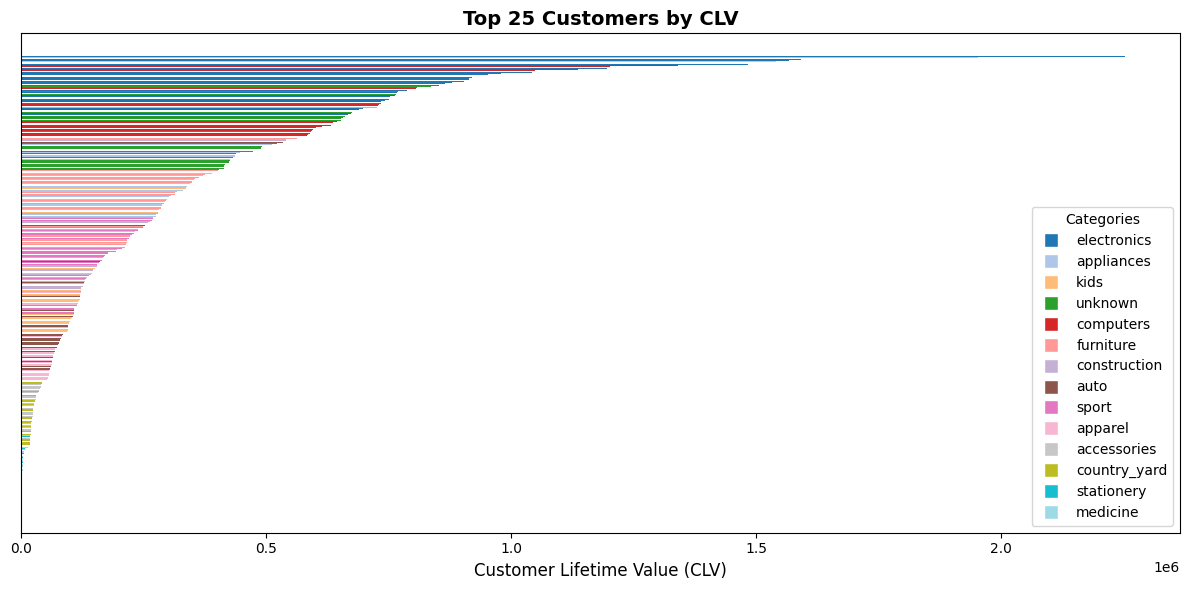

In [49]:
viz = QueryVisualizer(resultDf)
viz.plotTopCustomersBar(topN=25)

---

### **Q2. Identify Customers with Longest Gaps Between Purchase Events**

Long gaps in purchase behavior indicate **low engagement or churn risk**. Measuring gaps allows **retention-focused interventions**.

**SQL & Analysis Strategy:**

* **Step 1:** Filter only purchase events:

  * `event_type = 'purchase'` or `has_purchase = TRUE`.

* **Step 2:** Compute consecutive purchase gaps:

  * Use `LAG(event_time) OVER (PARTITION BY user_id ORDER BY event_time)` to get previous purchase.
  * Calculate gap: `event_time - previous_event_time`.

* **Step 3:** Aggregate per user:

  * Compute `MAX(gap)` per `user_id` to find the **longest gap**.

* **Step 4 (Optional):** Rank customers by longest gap:

  * Identify users at **highest churn risk**.

**Business Implication:**

* Customers with **long gaps** → candidates for **re-engagement campaigns**.
* Short gaps → highly engaged users; monitor for cross-sell opportunities.

**Key SQL Functions / Concepts:**

* `LAG()` (window function for previous value)
* `MAX()` (aggregation)
* `PARTITION BY user_id ORDER BY event_time`
* Timestamp arithmetic (`event_time - previous_event_time`)

---

In [57]:
query = """
WITH customer_lag AS (
	select
	user_id,
	event_time,
	LAG(event_time) OVER (
	  PARTITION BY user_id
	  ORDER BY event_time) AS previous_event_time
	from ecommerce_events
	where event_type = 'purchase'
	order by event_time asc
)

select user_id, 
max(event_time - previous_event_time) AS gap
from customer_lag where previous_event_time IS NOT NULL
group by user_id
order by gap desc
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 168392 rows
First row sample: (566289937, datetime.timedelta(days=29, seconds=61586))
shape: (168_392, 2)
┌───────────┬─────────────────┐
│ user_id   ┆ gap             │
│ ---       ┆ ---             │
│ i64       ┆ duration[μs]    │
╞═══════════╪═════════════════╡
│ 566289937 ┆ 29d 17h 6m 26s  │
│ 543394111 ┆ 29d 13h 18m 32s │
│ 515174168 ┆ 29d 12h 43m 7s  │
│ 566393046 ┆ 29d 12h 9m 15s  │
│ 513093370 ┆ 29d 10h 34m 13s │
│ …         ┆ …               │
│ 567762255 ┆ 1s              │
│ 566692291 ┆ 1s              │
│ 516458104 ┆ 1s              │
│ 536040053 ┆ 0µs             │
│ 559167872 ┆ 0µs             │
└───────────┴─────────────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


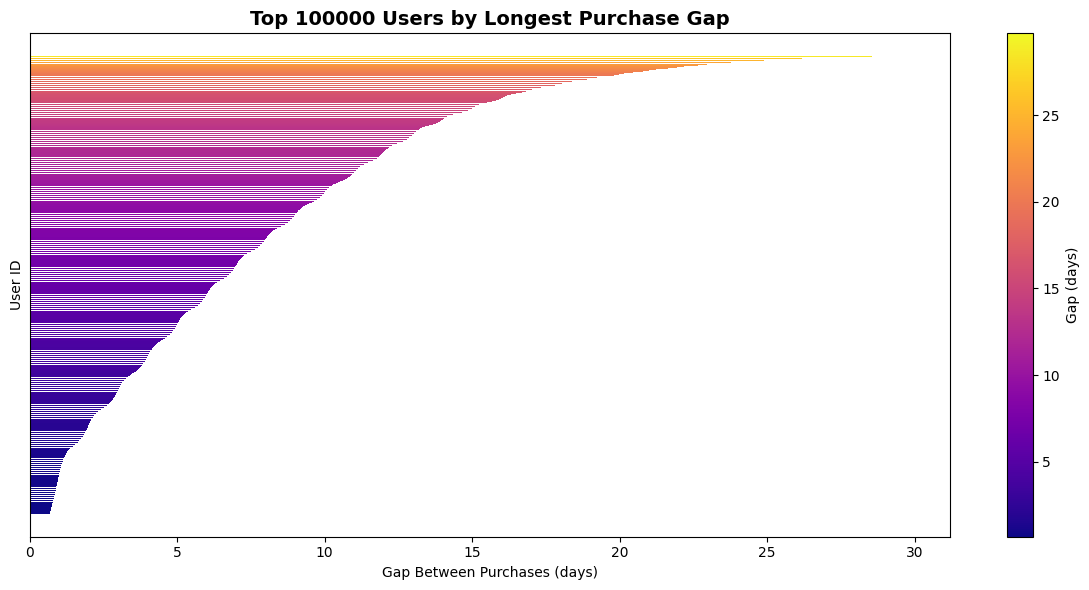

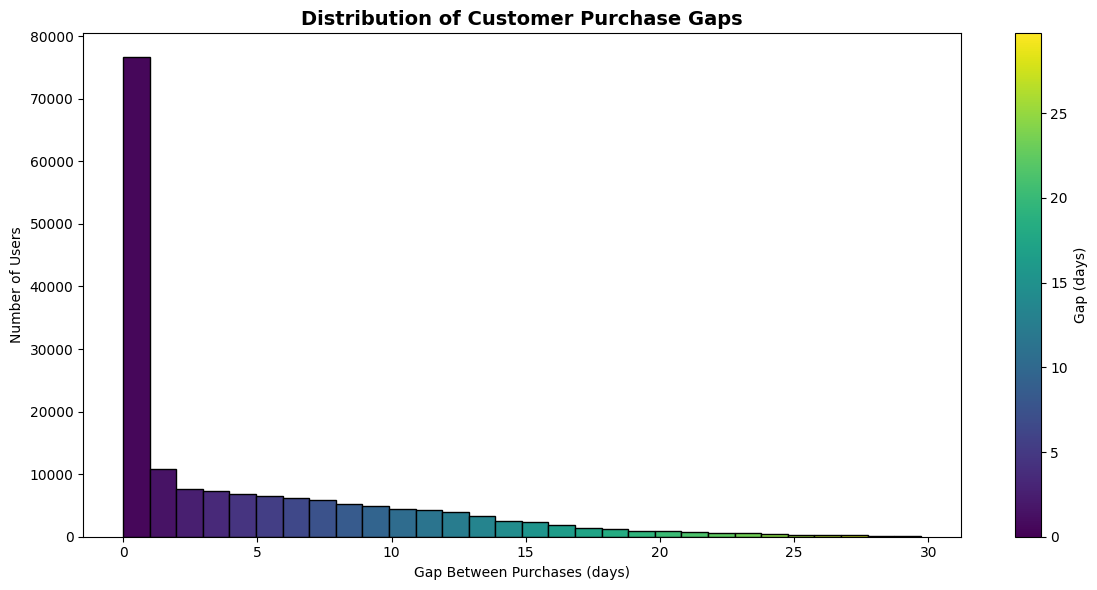

In [64]:
viz = QueryVisualizer(resultDf)
viz.plotLongestPurchaseGapBar(topN=100000)
viz.plotPurchaseGapDistribution(bins=30)

---

### **Q3. Rolling 30-Day Active Users & Month-over-Month Retention**

Rolling metrics capture **trends in user engagement**, while MoM retention evaluates **returning user behavior**.

**SQL & Analysis Strategy:**

**Step A – Rolling 30-Day Active Users**

* **Step 1:** Aggregate daily active users:

  * `COUNT(DISTINCT user_id)` grouped by `DATE(event_time)`.

* **Step 2:** Compute rolling 30-day active users:

  * Use **window function**:

    * `SUM(daily_users) OVER (ORDER BY day ROWS BETWEEN 29 PRECEDING AND CURRENT ROW)`
  * Ensures **current day + previous 29 days** are included.

* **Step 3 (Optional):** Fill missing days if needed:

  * `generate_series()` to ensure **continuous daily timeline**.

**Step B – Month-over-Month (MoM) Retention**

* **Step 1:** Bucket users by month: `DATE_TRUNC('month', event_time)`.
* **Step 2:** Identify users active in current and previous month.
* **Step 3:** Calculate retention rate:

$$
Retention_{MoM} = \frac{COUNT(users_{current} \cap users_{previous})}{COUNT(users_{previous})}
$$

**Business Implication:**

* Rolling 30-day users → monitor **trends and spikes in engagement**.
* MoM retention → evaluate **loyalty, retention programs**, and growth opportunities.

**Key SQL Functions / Concepts:**

* `COUNT(DISTINCT user_id)` (unique users)
* `DATE(event_time)` / `DATE_TRUNC('month', event_time)` (time bucketing)
* Window functions: `SUM(...) OVER (...)` for rolling metrics
* Self-joins or CTEs for retention calculations

---

In [69]:
query = """
WITH customer_rolling AS(
SELECT DATE(event_time) AS day,
COUNT(DISTINCT user_id) AS daily_users
from ecommerce_events
group by day
)

select
day,
SUM(daily_users) OVER (
        ORDER BY day
        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
    ) AS rolling_30d_active_users
from customer_rolling
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 30 rows
First row sample: (datetime.date(2019, 11, 1), Decimal('223108'))
shape: (30, 2)
┌────────────┬──────────────────────────┐
│ day        ┆ rolling_30d_active_users │
│ ---        ┆ ---                      │
│ date       ┆ decimal[*,0]             │
╞════════════╪══════════════════════════╡
│ 2019-11-01 ┆ 223108                   │
│ 2019-11-02 ┆ 457793                   │
│ 2019-11-03 ┆ 697980                   │
│ 2019-11-04 ┆ 973592                   │
│ 2019-11-05 ┆ 1235930                  │
│ …          ┆ …                        │
│ 2019-11-26 ┆ 7568699                  │
│ 2019-11-27 ┆ 7825245                  │
│ 2019-11-28 ┆ 8079224                  │
│ 2019-11-29 ┆ 8365923                  │
│ 2019-11-30 ┆ 8621420                  │
└────────────┴──────────────────────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


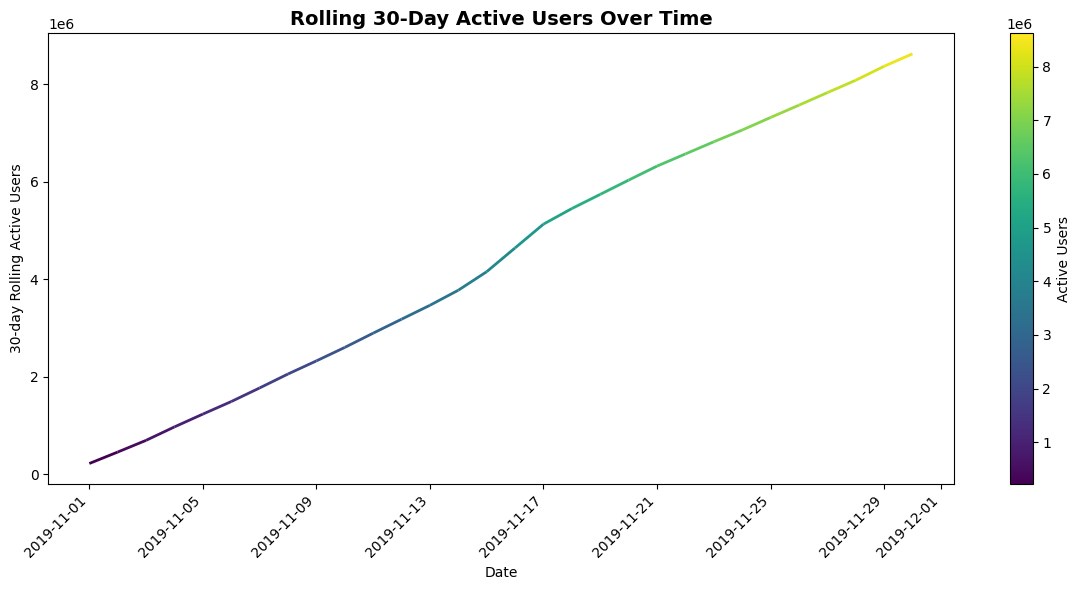

In [77]:
viz = QueryVisualizer(resultDf)
viz.plotRollingActiveUsers()


---


## **Task 2.2 – Product Performance & Cross-Selling (Q4–Q6)**

---

### **Q4: Products with Highest Conversion Rate (View → Purchase)**

**Objective:**
Identify products that **most efficiently convert views into purchases**, i.e., which products have the highest probability that a view results in a purchase.

**Analytical Strategy:**

* **Step 1 – Count views and purchases per product:**

  * Count events where `event_type = 'view'` → denominator.
  * Count events where `event_type = 'purchase'` → numerator.

* **Step 2 – Calculate conversion rate:**

$$
\text{Conversion Rate} = \frac{\text{Number of Purchases}}{\text{Number of Views}}
$$

* **Step 3 – Handle edge cases:**

  * Avoid division by zero (products with zero views).

* **Step 4 – Rank products by conversion rate:**

  * Helps identify **highly effective products** for marketing and inventory decisions.

**Business Implication:**

* High-conversion products → good candidates for promotion, upselling, or bundling.
* Low-conversion products → may require better product detail pages or targeted campaigns.

---




In [78]:
query="""
SELECT product_id,
round((COUNT(event_type) FILTER (WHERE event_type = 'purchase')* 1.0/
NULLIF(COUNT(event_type) FILTER (WHERE event_type = 'view'), 0)), 5) as conversion_rate
FROM ecommerce_events
group by product_id
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 190662 rows
First row sample: (1000365, Decimal('0.00000'))
shape: (190_662, 2)
┌────────────┬─────────────────┐
│ product_id ┆ conversion_rate │
│ ---        ┆ ---             │
│ i64        ┆ decimal[*,5]    │
╞════════════╪═════════════════╡
│ 1000365    ┆ 0.00000         │
│ 1000978    ┆ 0.00275         │
│ 1001588    ┆ 0.00350         │
│ 1001606    ┆ 0.00000         │
│ 1001618    ┆ 0.02402         │
│ …          ┆ …               │
│ 100028525  ┆ 0.00000         │
│ 100028530  ┆ 0.00000         │
│ 100028536  ┆ 0.00000         │
│ 100028537  ┆ 0.00000         │
│ 100028554  ┆ 0.00000         │
└────────────┴─────────────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


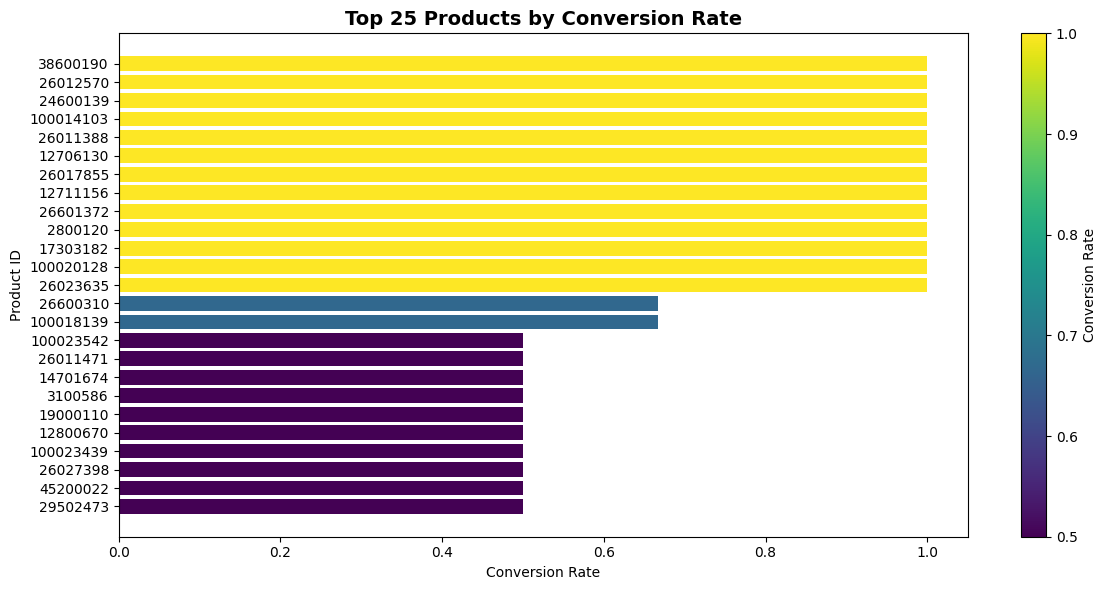

In [84]:
viz = QueryVisualizer(resultDf)
viz.plotProductConversionRate(topN=25)

---

### **Q5: Product Category Performance Hierarchies Using CTEs**

**Objective:**
Analyze **product performance across category hierarchies** (product → category_l3 → category_l2 → category_l1) for revenue and conversion insights.

**Analytical Strategy:**

* **Step 1 – Aggregate metrics per product:**

  * Count views, count purchases, sum revenue, compute conversion rate.

* **Step 2 – Aggregate metrics per category level:**

  * Repeat the same aggregation for `category_l3`, `category_l2`, and `category_l1`.
  * Use **CTEs** to organize calculations for each level.

* **Step 3 – Optional:**

  * Query any level as needed (product, category_l3, etc.) using the precomputed CTEs.

**Business Implication:**

* Understand **which categories and products drive revenue and conversion**.
* Helps with **inventory planning, promotion targeting, and category-level KPIs**.

---

In [88]:
# Product-level stats
productStatsQuery = """
SELECT
    product_id,
    COUNT(event_type) FILTER (WHERE event_type = 'view') AS views_count,
    COUNT(event_type) FILTER (WHERE event_type = 'purchase') AS purchases_count,
    SUM(price) AS revenue,
    ROUND(
        COUNT(event_type) FILTER (WHERE event_type = 'purchase') * 1.0 /
        NULLIF(COUNT(event_type) FILTER (WHERE event_type = 'view'), 0), 5
    ) AS conversion_rate
FROM ecommerce_events
GROUP BY product_id
ORDER BY purchases_count DESC;
"""

# Category L3-level stats
categoryL3StatsQuery = """
SELECT
    category_l3,
    COUNT(event_type) FILTER (WHERE event_type = 'view') AS views_count,
    COUNT(event_type) FILTER (WHERE event_type = 'purchase') AS purchases_count,
    SUM(price) AS revenue,
    ROUND(
        COUNT(event_type) FILTER (WHERE event_type = 'purchase') * 1.0 /
        NULLIF(COUNT(event_type) FILTER (WHERE event_type = 'view'), 0), 5
    ) AS conversion_rate
FROM ecommerce_events
GROUP BY category_l3
ORDER BY purchases_count DESC;
"""

# Category L2-level stats
categoryL2StatsQuery = """
SELECT
    category_l2,
    COUNT(event_type) FILTER (WHERE event_type = 'view') AS views_count,
    COUNT(event_type) FILTER (WHERE event_type = 'purchase') AS purchases_count,
    SUM(price) AS revenue,
    ROUND(
        COUNT(event_type) FILTER (WHERE event_type = 'purchase') * 1.0 /
        NULLIF(COUNT(event_type) FILTER (WHERE event_type = 'view'), 0), 5
    ) AS conversion_rate
FROM ecommerce_events
GROUP BY category_l2
ORDER BY purchases_count DESC;
"""

# Category L1-level stats
categoryL1StatsQuery = """
SELECT
    category_l1,
    COUNT(event_type) FILTER (WHERE event_type = 'view') AS views_count,
    COUNT(event_type) FILTER (WHERE event_type = 'purchase') AS purchases_count,
    SUM(price) AS revenue,
    ROUND(
        COUNT(event_type) FILTER (WHERE event_type = 'purchase') * 1.0 /
        NULLIF(COUNT(event_type) FILTER (WHERE event_type = 'view'), 0), 5
    ) AS conversion_rate
FROM ecommerce_events
GROUP BY category_l1
ORDER BY purchases_count DESC;
"""

In [91]:
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=productStatsQuery)
print(resultDf)

Query returned 190662 rows
First row sample: (1004856, 522880, 32321, Decimal('80997844.47'), Decimal('0.06181'))


C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


shape: (190_662, 5)
┌────────────┬─────────────┬─────────────────┬──────────────┬─────────────────┐
│ product_id ┆ views_count ┆ purchases_count ┆ revenue      ┆ conversion_rate │
│ ---        ┆ ---         ┆ ---             ┆ ---          ┆ ---             │
│ i64        ┆ i64         ┆ i64             ┆ decimal[*,2] ┆ decimal[*,5]    │
╞════════════╪═════════════╪═════════════════╪══════════════╪═════════════════╡
│ 1004856    ┆ 522880      ┆ 32321           ┆ 80997844.47  ┆ 0.06181         │
│ 1004767    ┆ 482898      ┆ 22613           ┆ 140070134.05 ┆ 0.04683         │
│ 1005115    ┆ 583010      ┆ 22244           ┆ 619370131.61 ┆ 0.03815         │
│ 4804056    ┆ 318339      ┆ 17800           ┆ 63645354.56  ┆ 0.05592         │
│ 1004833    ┆ 247446      ┆ 13486           ┆ 50383276.26  ┆ 0.05450         │
│ …          ┆ …           ┆ …               ┆ …            ┆ …               │
│ 15901517   ┆ 236         ┆ 0               ┆ 8374.75      ┆ 0.00000         │
│ 15901522   ┆ 51   

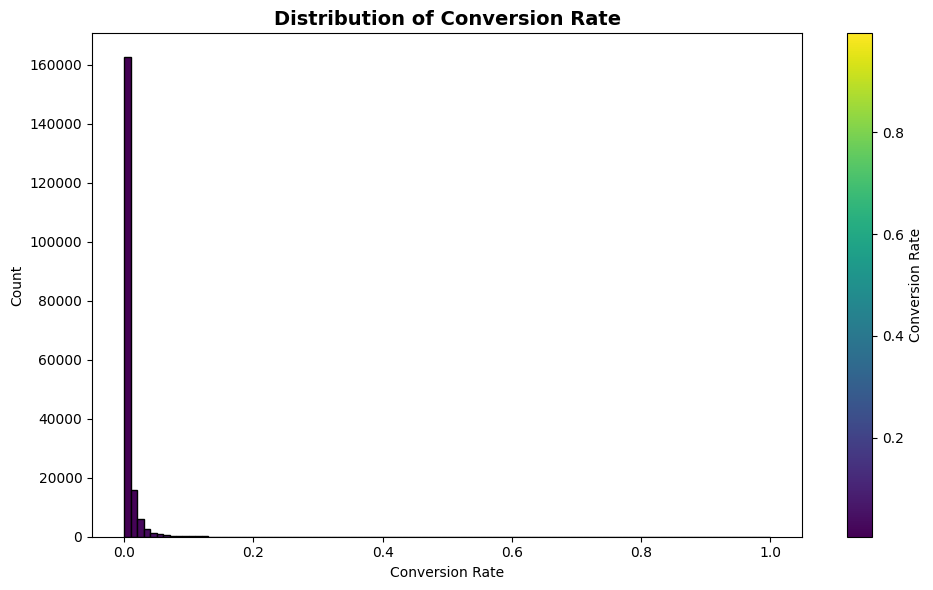

In [103]:
viz = QueryVisualizer(resultDf)
viz.plotConversionHistogram(col="conversion_rate", bins=100, cmap="viridis")

In [121]:
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=categoryL1StatsQuery)
print(resultDf)

Query returned 14 rows
First row sample: ('electronics', 21988192, 493639, Decimal('10181925333.80'), Decimal('0.02245'))
shape: (14, 5)
┌──────────────┬─────────────┬─────────────────┬────────────────┬─────────────────┐
│ category_l1  ┆ views_count ┆ purchases_count ┆ revenue        ┆ conversion_rate │
│ ---          ┆ ---         ┆ ---             ┆ ---            ┆ ---             │
│ str          ┆ i64         ┆ i64             ┆ decimal[*,2]   ┆ decimal[*,5]    │
╞══════════════╪═════════════╪═════════════════╪════════════════╪═════════════════╡
│ electronics  ┆ 21988192    ┆ 493639          ┆ 10181925333.80 ┆ 0.02245         │
│ unknown      ┆ 20837460    ┆ 234218          ┆ 3868232750.04  ┆ 0.01124         │
│ appliances   ┆ 8037980     ┆ 99026           ┆ 1986725148.92  ┆ 0.01232         │
│ computers    ┆ 4029049     ┆ 34477           ┆ 2235192038.04  ┆ 0.00856         │
│ apparel      ┆ 2942622     ┆ 14215           ┆ 252242886.94   ┆ 0.00483         │
│ …            ┆ …     

C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


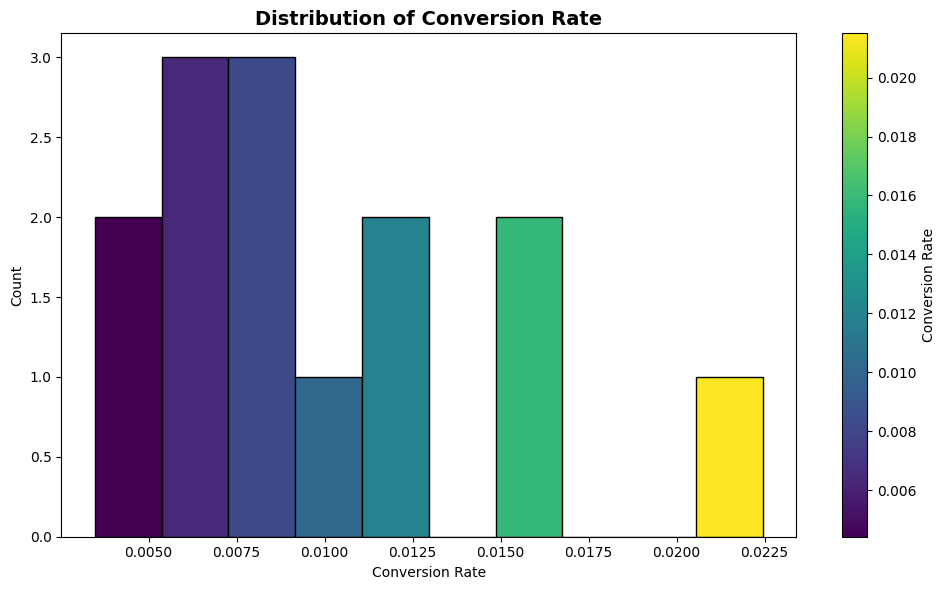

In [125]:
viz = QueryVisualizer(resultDf)
viz.plotConversionHistogram(col="conversion_rate", bins=10, cmap="viridis")

In [119]:
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=categoryL2StatsQuery)
print(resultDf)

Query returned 62 rows
First row sample: ('electronics.smartphone', 14832387, 382647, Decimal('7919567208.81'), Decimal('0.02580'))
shape: (62, 5)
┌────────────────────────┬─────────────┬─────────────────┬───────────────┬─────────────────┐
│ category_l2            ┆ views_count ┆ purchases_count ┆ revenue       ┆ conversion_rate │
│ ---                    ┆ ---         ┆ ---             ┆ ---           ┆ ---             │
│ str                    ┆ i64         ┆ i64             ┆ decimal[*,2]  ┆ decimal[*,5]    │
╞════════════════════════╪═════════════╪═════════════════╪═══════════════╪═════════════════╡
│ electronics.smartphone ┆ 14832387    ┆ 382647          ┆ 7919567208.81 ┆ 0.02580         │
│ unknown                ┆ 20837460    ┆ 234218          ┆ 3868232750.04 ┆ 0.01124         │
│ appliances.kitchen     ┆ 5207485     ┆ 61341           ┆ 1509377553.10 ┆ 0.01178         │
│ electronics.audio      ┆ 2193152     ┆ 46302           ┆ 339400615.75  ┆ 0.02111         │
│ electronics.vi

C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


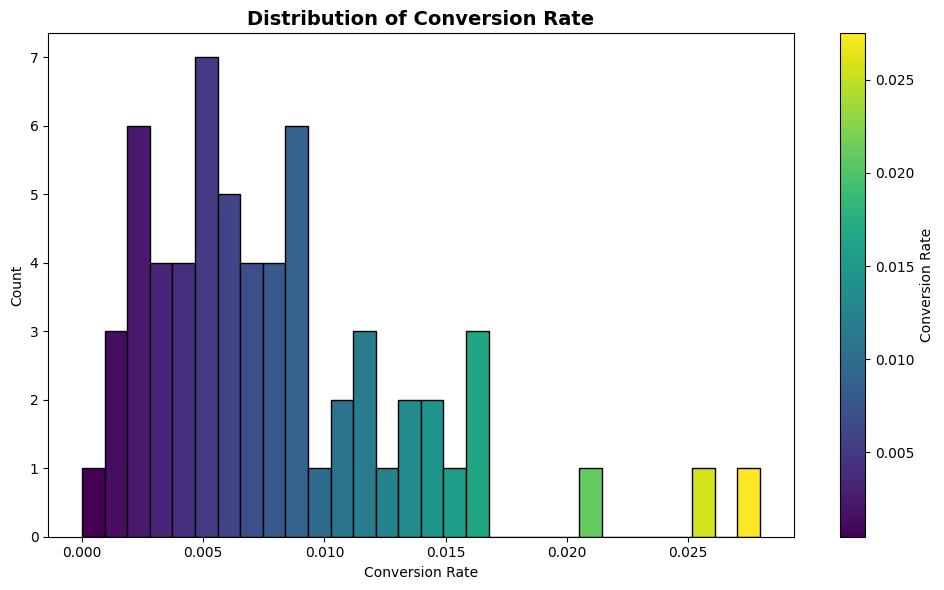

In [120]:
viz = QueryVisualizer(resultDf)
viz.plotConversionHistogram(col="conversion_rate", bins=30, cmap="viridis")

In [115]:
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=categoryL3StatsQuery)
print(resultDf)

Query returned 86 rows
First row sample: ('unknown', 45708683, 702740, Decimal('15172009867.58'), Decimal('0.01537'))
shape: (86, 5)
┌─────────────┬─────────────┬─────────────────┬────────────────┬─────────────────┐
│ category_l3 ┆ views_count ┆ purchases_count ┆ revenue        ┆ conversion_rate │
│ ---         ┆ ---         ┆ ---             ┆ ---            ┆ ---             │
│ str         ┆ i64         ┆ i64             ┆ decimal[*,2]   ┆ decimal[*,5]    │
╞═════════════╪═════════════╪═════════════════╪════════════════╪═════════════════╡
│ unknown     ┆ 45708683    ┆ 702740          ┆ 15172009867.58 ┆ 0.01537         │
│ headphone   ┆ 1644910     ┆ 40834           ┆ 231246632.48   ┆ 0.02482         │
│ tv          ┆ 2071305     ┆ 30274           ┆ 1038465044.22  ┆ 0.01462         │
│ washer      ┆ 1313807     ┆ 19772           ┆ 478158393.39   ┆ 0.01505         │
│ vacuum      ┆ 1445029     ┆ 18193           ┆ 281950328.00   ┆ 0.01259         │
│ …           ┆ …           ┆ …      

C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


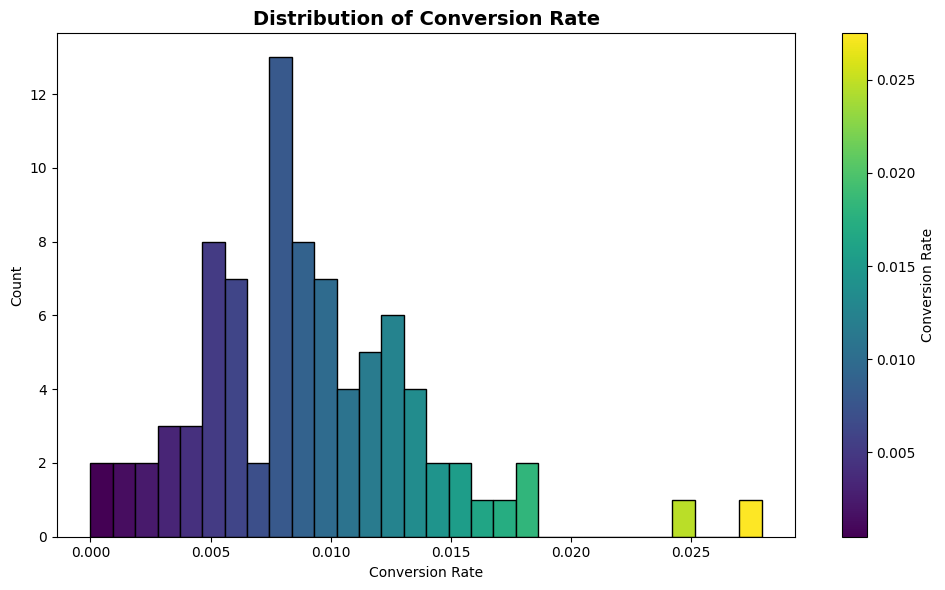

In [118]:
viz = QueryVisualizer(resultDf)
viz.plotConversionHistogram(col="conversion_rate", bins=30, cmap="viridis")

---

### **Q6: Product Affinity Scores & Cross-Selling Opportunities**

**Objective:**
Identify **products frequently purchased together** to inform cross-selling, bundling, and recommendation strategies.

**Analytical Strategy:**

* **Step 1 – Identify multi-product purchase sessions:**

  * Aggregate `product_id`s per `user_session`.
  * Filter sessions with more than 1 purchase.

* **Step 2 – Unnest products into rows:**

  * Convert arrays of products into separate rows per session.

* **Step 3 – Generate product pairs per session:**

  * Self-join on `user_session` to get all product combinations.
  * Keep unique pairs (`product1 < product2`) to avoid duplicates.

* **Step 4 – Aggregate pair counts across sessions:**

  * Count sessions containing both products → numerator.
  * Count sessions containing `product1` → denominator.

* **Step 5 – Compute affinity score:**

$$
\text{Affinity Score} = \frac{\text{Sessions with both products}}{\text{Sessions with product1}}
$$

* **Step 6 – Interpret results:**

  * Score ≈ 1 → products always bought together → strong cross-sell.
  * Score ≈ 0 → products rarely bought together → weak cross-sell.

**Business Implication:**

* High-affinity pairs → promote as bundles or recommendations.
* Low-affinity pairs → explore new cross-sell opportunities or ignore.

---

In [126]:
query="""
with purchase_sessions as (
	select user_session,
	ARRAY_AGG(product_id) as products_arr,
	COUNT(event_type) FILTER (WHERE event_type = 'purchase') as purchases_count
	from ecommerce_events
	group by user_session
),

purchase_sessions_multi as (
select user_session, UNNEST(products_arr) as product_id from purchase_sessions
where purchases_count > 1
),

purchase_cross as (SELECT 
        p1.user_session, 
        p1.product_id AS product1, 
        p2.product_id AS product2
from purchase_sessions_multi p1 join purchase_sessions_multi p2
on p1.user_session = p2.user_session where p1.product_id < p2.product_id
),

pair_counts AS (
    SELECT 
        product1, 
        product2, 
        COUNT(DISTINCT user_session) AS pair_sessions
    FROM purchase_cross
    GROUP BY product1, product2
),

product_sessions AS (
    SELECT 
        product_id, 
        COUNT(DISTINCT user_session) AS product_sessions
    FROM purchase_sessions_multi
    GROUP BY product_id
)
SELECT 
    pc.product1,
    pc.product2,
    pc.pair_sessions,
    ps.product_sessions,
    ROUND(pc.pair_sessions::numeric / ps.product_sessions, 5) AS affinity_score
FROM pair_counts pc
JOIN product_sessions ps
  ON pc.product1 = ps.product_id
ORDER BY affinity_score DESC
LIMIT 50;
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)


Query returned 50 rows
First row sample: (1003014, 8801085, 1, 1, Decimal('1.00000'))
shape: (50, 5)
┌──────────┬──────────┬───────────────┬──────────────────┬────────────────┐
│ product1 ┆ product2 ┆ pair_sessions ┆ product_sessions ┆ affinity_score │
│ ---      ┆ ---      ┆ ---           ┆ ---              ┆ ---            │
│ i64      ┆ i64      ┆ i64           ┆ i64              ┆ decimal[*,5]   │
╞══════════╪══════════╪═══════════════╪══════════════════╪════════════════╡
│ 1003014  ┆ 8801085  ┆ 1             ┆ 1                ┆ 1.00000        │
│ 1003014  ┆ 21403791 ┆ 1             ┆ 1                ┆ 1.00000        │
│ 1003014  ┆ 5100691  ┆ 1             ┆ 1                ┆ 1.00000        │
│ 1002398  ┆ 1004767  ┆ 1             ┆ 1                ┆ 1.00000        │
│ 1002876  ┆ 1004856  ┆ 1             ┆ 1                ┆ 1.00000        │
│ …        ┆ …        ┆ …             ┆ …                ┆ …              │
│ 1002396  ┆ 1004395  ┆ 1             ┆ 1                ┆ 1.00

C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)



---

## **Q7: Identify Seasonal Trends & YoY Growth** *(not applicable for 1-month data, but structured approach if multi-year data were available)*

**Objective:**
Identify seasonal patterns in purchases or views and compute **year-over-year growth**.

**Analytical Strategy:**

* **Step 1 – Aggregate data by period:**

  * Aggregate `event_type = 'purchase'` by `MONTH(event_time)` and `YEAR(event_time)` (or by week/day for intra-month trends).
  * Compute counts or revenue per period.

* **Step 2 – Compute growth rates:**
  $$
  \text{YoY Growth} = \frac{\text{Current Period Value} - \text{Value in Same Period Last Year}}{\text{Value in Same Period Last Year}}
  $$

  * For seasonal trends, plot counts by month/week to see spikes.

* **Step 3 – Handle edge cases:**

  * Missing data for some months → treat as 0 or NULL.
  * Consider outlier days (e.g., Black Friday) separately to avoid skewing averages.

**Business Interpretation:**

* Helps marketing plan **campaigns aligned with seasonal spikes**.
* Inventory planning: stock more during high-season months.
* Detect long-term growth or decline trends.

**SQL Structure Guidance:**

* Use a **CTE** to aggregate counts/revenue per period.
* Use `LAG()` or joins to calculate YoY growth.
* Optional: `ROW_NUMBER()` or `RANK()` to detect top seasonal months.







---

## **Q8: Peak Shopping Hours & Day-of-Week Patterns**

**Objective:**
Understand **when users engage most** (hour of day or weekday), both in terms of volume and efficiency.

**Analytical Strategy:**

* **Step 1 – Aggregate events by hour/day:**

  * Use `sessionStartHour` and `sessionDayOfWeek`.
  * Count `views` and `purchases`.

* **Step 2 – Calculate distribution and conversion rate:**
  $$
  \text{Conversion Rate} = \frac{\text{Purchases in Hour/Day}}{\text{Views in Hour/Day}}
  $$

  * Compute share of total purchases and views per hour/day.

* **Step 3 – Handle edge cases:**

  * Missing hours/days → fill zeros or include all hours 0–23 and weekdays Mon–Sun.
  * Adjust for partial sessions at midnight.

**Business Interpretation:**

* Timing of **push notifications or campaigns**.
* Allocate support or logistics resources during peak hours.
* Detect unusual spikes in off-peak hours (possible fraud or bots).

**SQL Structure Guidance:**

* **CTEs** to aggregate purchases and views separately.
* **Window functions** to calculate shares and ranks.
* **Join** views and purchases to compute conversion rate per hour/day.

---

In [141]:
# Query for sessions per hour for purchases
sessionsPerHourPurchaseQuery = """
SELECT
    sessionStartHour,
    COUNT(user_session) AS sessionCount
FROM
    ecommerce_events
WHERE
    event_type = 'purchase'
GROUP BY
    sessionStartHour
ORDER BY
    sessionStartHour;
"""

# Query for sessions per hour for views
sessionsPerHourViewQuery = """
SELECT
    sessionStartHour,
    COUNT(user_session) AS sessionCount
FROM
    ecommerce_events
WHERE
    event_type = 'view'
GROUP BY
    sessionStartHour
ORDER BY
    sessionStartHour;
"""

In [147]:
resultDfPurchase = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=sessionsPerHourPurchaseQuery)
print(resultDfPurchase)

Query returned 24 rows
First row sample: (0, 2872)
shape: (24, 2)
┌──────────────────┬──────────────┐
│ sessionstarthour ┆ sessioncount │
│ ---              ┆ ---          │
│ i64              ┆ i64          │
╞══════════════════╪══════════════╡
│ 0                ┆ 2872         │
│ 1                ┆ 4779         │
│ 2                ┆ 12245        │
│ 3                ┆ 29445        │
│ 4                ┆ 46020        │
│ …                ┆ …            │
│ 19               ┆ 15960        │
│ 20               ┆ 9587         │
│ 21               ┆ 6070         │
│ 22               ┆ 4035         │
│ 23               ┆ 2751         │
└──────────────────┴──────────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


In [148]:
resultDfView = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=sessionsPerHourViewQuery)
print(resultDfView)

Query returned 24 rows
First row sample: (0, 458706)
shape: (24, 2)
┌──────────────────┬──────────────┐
│ sessionstarthour ┆ sessioncount │
│ ---              ┆ ---          │
│ i64              ┆ i64          │
╞══════════════════╪══════════════╡
│ 0                ┆ 458706       │
│ 1                ┆ 880425       │
│ 2                ┆ 1716355      │
│ 3                ┆ 2319788      │
│ 4                ┆ 2989928      │
│ …                ┆ …            │
│ 19               ┆ 2112667      │
│ 20               ┆ 1240159      │
│ 21               ┆ 706699       │
│ 22               ┆ 424626       │
│ 23               ┆ 312103       │
└──────────────────┴──────────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


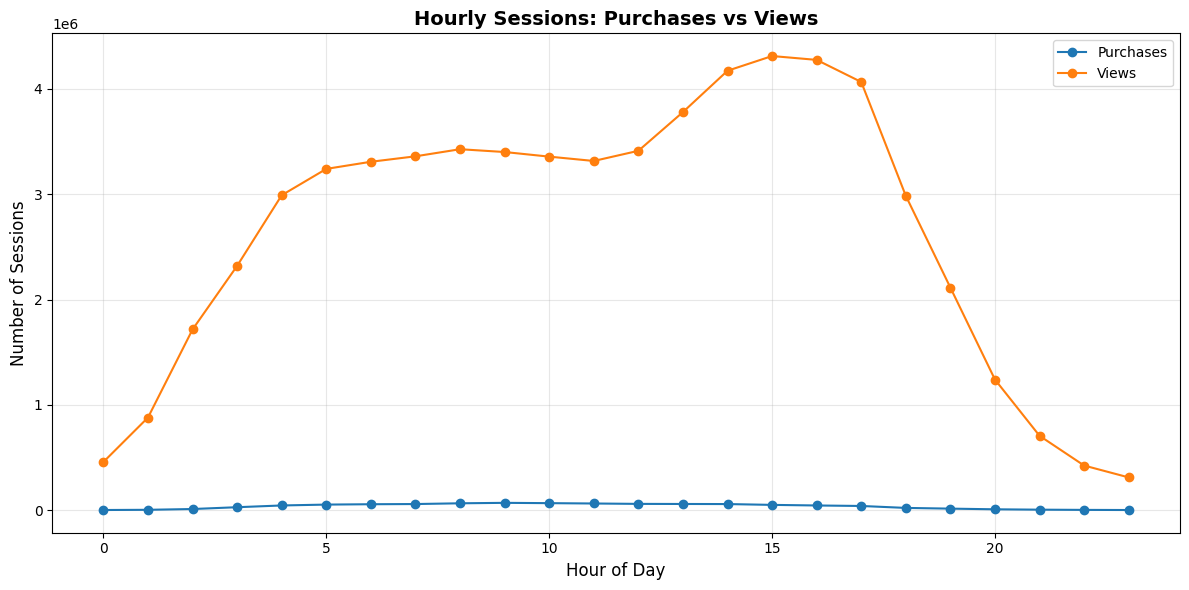

In [190]:
# Rename columns
dfPurchase = resultDfPurchase.rename({"sessioncount": "purchasesessioncount"})
dfView = resultDfView.rename({"sessioncount": "viewsessioncount"})

# Full outer join using the new Polars enum
dfHourly = dfPurchase.join(
    dfView,
    on="sessionstarthour",
    how='full'
)

# Fill missing values with 0
dfHourly = dfHourly.fill_null(0)

# Convert to Pandas for plotting only if it's Polars
if isinstance(dfHourly, pl.DataFrame):
    dfHourlyPd = dfHourly.to_pandas()
else:
    dfHourlyPd = dfHourly  # already Pandas

# Use your visualizer
viz = QueryVisualizer(dfHourlyPd)
viz.plotHourlySessionsComparison()

In [208]:
query = """
WITH sessions_per_hour_purchase AS (
	SELECT
		sessionStartHour,
		COUNT(user_session) as session_count
	FROM
		ecommerce_events
	WHERE
		event_type = 'purchase'
	GROUP BY
		sessionStartHour
),

sessions_per_hour_view AS (
	SELECT
		sessionStartHour,
		COUNT(user_session) as session_count
	FROM
		ecommerce_events
	WHERE
		event_type = 'view'
	GROUP BY
		sessionStartHour
)

SELECT
	p.sessionStartHour,
	p.session_count * 1.0 / SUM(p.session_count)
	over () AS purchase_share,
	v.session_count * 1.0 / SUM(v.session_count)
	over () AS view_share,
	p.session_count * 1.0 / v.session_count as conversion_rate_per_day
FROM
	sessions_per_hour_purchase p
FULL JOIN
	sessions_per_hour_view v
ON
	p.sessionStartHour = v.sessionStartHour
ORDER BY
	sessionStartHour asc
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 24 rows
First row sample: (0, Decimal('0.00313216037271835967'), Decimal('0.00721733913545054913'), Decimal('0.00626109098202334393'))
shape: (24, 4)
┌──────────────────┬────────────────────────┬────────────────────────┬─────────────────────────┐
│ sessionstarthour ┆ purchase_share         ┆ view_share             ┆ conversion_rate_per_day │
│ ---              ┆ ---                    ┆ ---                    ┆ ---                     │
│ i64              ┆ decimal[*,20]          ┆ decimal[*,20]          ┆ decimal[*,20]           │
╞══════════════════╪════════════════════════╪════════════════════════╪═════════════════════════╡
│ 0                ┆ 0.00313216037271835967 ┆ 0.00721733913545054913 ┆ 0.00626109098202334393  │
│ 1                ┆ 0.00521190613552264654 ┆ 0.01385272006106100578 ┆ 0.00542806031178124201  │
│ 2                ┆ 0.01335421440248478906 ┆ 0.02700535007570475915 ┆ 0.00713430496604723382  │
│ 3                ┆ 0.03211227791597914365 ┆ 0.03649984242

C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


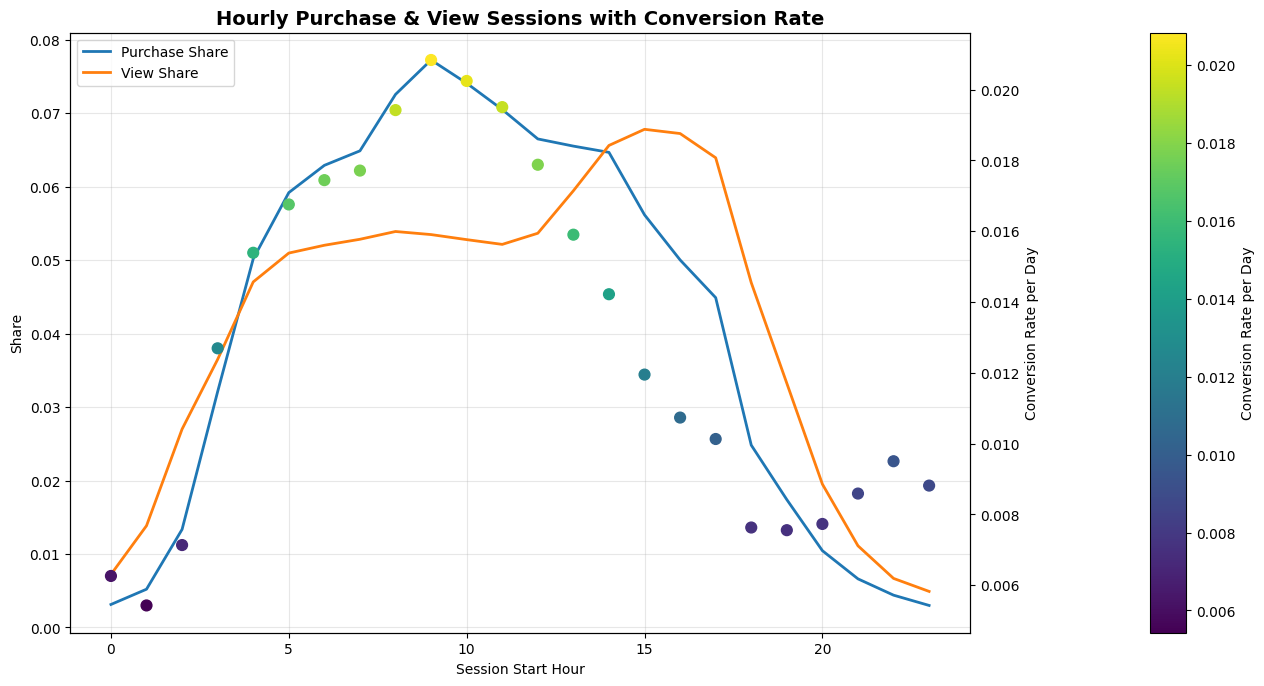

In [216]:
viz = QueryVisualizer(resultDf)
viz.plotHourlySessionsComparisonV2()

In [217]:
query = """
WITH sessions_per_day_purchase AS (
	SELECT
		sessionDayOfWeek,
		COUNT(user_session) as session_count
	FROM
		ecommerce_events
	WHERE
		event_type = 'purchase'
	GROUP BY
		sessionDayOfWeek
),

sessions_per_day_views AS (
	SELECT
		sessionDayOfWeek,
		COUNT(user_session) as session_count
	FROM
		ecommerce_events
	WHERE
		event_type = 'view'
	GROUP BY
		sessionDayOfWeek
)

SELECT
	p.sessionDayOfWeek,
	p.session_count * 1.0 / SUM(p.session_count)
	over () AS purchase_share,
	v.session_count * 1.0 / SUM(v.session_count)
	over () AS view_share,
	p.session_count * 1.0 / v.session_count as conversion_rate_per_day
FROM
	sessions_per_day_purchase p
FULL JOIN 
	sessions_per_day_views v
ON
	p.sessionDayOfWeek = v.sessionDayOfWeek
ORDER BY
	conversion_rate_per_day desc
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 7 rows
First row sample: ('Sunday', Decimal('0.27637716358449144381'), Decimal('0.16757084409351044298'), Decimal('0.02379506168504089754'))
shape: (7, 4)
┌──────────────────┬────────────────────────┬────────────────────────┬─────────────────────────┐
│ sessiondayofweek ┆ purchase_share         ┆ view_share             ┆ conversion_rate_per_day │
│ ---              ┆ ---                    ┆ ---                    ┆ ---                     │
│ str              ┆ decimal[*,20]          ┆ decimal[*,20]          ┆ decimal[*,20]           │
╞══════════════════╪════════════════════════╪════════════════════════╪═════════════════════════╡
│ Sunday           ┆ 0.27637716358449144381 ┆ 0.16757084409351044298 ┆ 0.02379506168504089754  │
│ Monday           ┆ 0.11469574311922603357 ┆ 0.11109964093145411197 ┆ 0.01489422057110114188  │
│ Wednesday        ┆ 0.10610193262583443392 ┆ 0.10589970028058671306 ┆ 0.01445478713327973710  │
│ Tuesday          ┆ 0.10551737901866972612 ┆ 0.106334

C:\Users\negam\AppData\Local\Temp\ipykernel_8316\2331944289.py:245: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


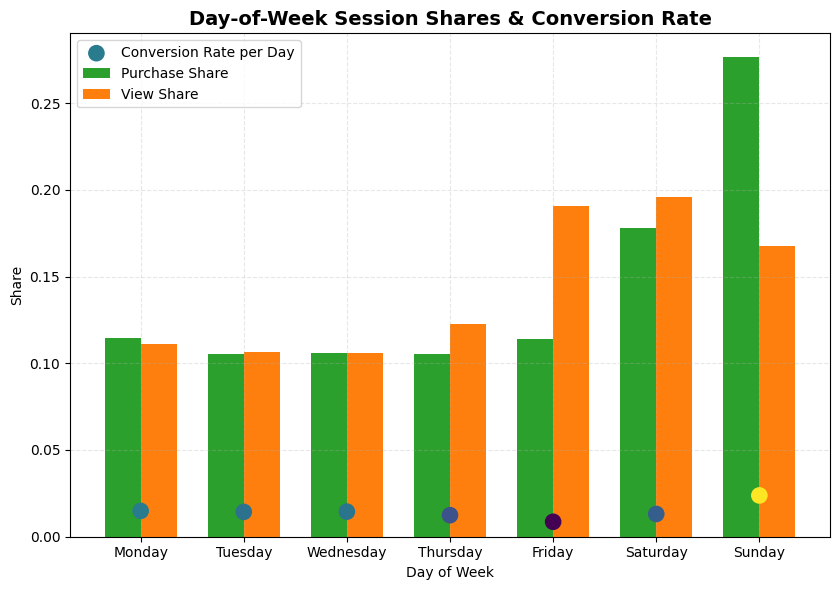

In [236]:
viz = QueryVisualizer(resultDf)
viz.plotDayOfWeekSessions()

---

## **Q9: Moving Averages & Anomaly Detection**

**Objective:**
Smooth daily purchase/revenue trends and **identify anomalies** (unexpected spikes or drops).

**Analytical Strategy:**

* **Step 1 – Aggregate daily metrics:**

  * Count `session_count` or sum `daily_revenue` grouped by `DATE(event_time)`.

* **Step 2 – Compute moving average:**
  $$
  \text{MA}*n = \frac{\text{Day}*{t-n+1} + \ldots + \text{Day}_t}{n}
  $$

  * Use a 3–7 day rolling window depending on dataset length.

* **Step 3 – Identify anomalies:**
  $$
  \text{Deviation} = \frac{\text{Actual} - \text{MA}}{\text{MA}}
  $$

  * Flag days where |Deviation| > threshold (e.g., 30%).
  * Optionally detect both spikes and drops.

* **Step 4 – Handle edge cases:**

  * First `n-1` days → partial window.
  * Low volume days → may appear as anomalies naturally.
  * Consider separating out special promo/holiday days.

**Business Interpretation:**

* Alerts marketing, operations, and finance teams to unusual trends.
* Supports **forecasting and capacity planning**.
* Helps detect fraud or technical issues if spikes/drops are unexplained.

**SQL Structure Guidance:**

* **CTE 1:** Aggregate daily counts and revenue.
* **CTE 2:** Compute moving average using `AVG() OVER (ORDER BY event_date ROWS BETWEEN n-1 PRECEDING AND CURRENT ROW)`.
* **Final SELECT:** Compute deviation and flag anomalies using `CASE WHEN ABS(...) > threshold THEN TRUE ELSE FALSE END`.

---

In [5]:
query = """
WITH daily_count AS (
    SELECT
        DATE(event_time) AS event_date,
        COUNT(user_session) AS session_count,
        SUM(price) AS daily_revenue
    FROM
        ecommerce_events
    WHERE
        event_type = 'purchase'
    GROUP BY event_date
),
moving_average AS (
    SELECT
        event_date,
        session_count,
        daily_revenue,
        AVG(session_count) OVER (ORDER BY event_date
            ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg_session,
        AVG(daily_revenue) OVER (ORDER BY event_date
            ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg_revenue
    FROM
        daily_count
)
SELECT *,
    CASE 
        WHEN ABS((session_count - moving_avg_session) / moving_avg_session) > 0.30
        THEN TRUE ELSE FALSE 
    END AS is_anomaly_session,
    CASE 
        WHEN ABS((daily_revenue - moving_avg_revenue) / moving_avg_revenue) > 0.30
        THEN TRUE ELSE FALSE 
    END AS is_anomaly_revenue
FROM 
    moving_average;
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 29 rows
First row sample: (datetime.date(2019, 11, 1), 22458, Decimal('6949415.03'), Decimal('22458.000000000000'), Decimal('6949415.030000000000'), False, False)


C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


shape: (29, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ event_date ┆ session_coun ┆ daily_revenu ┆ moving_avg_ ┆ moving_avg_ ┆ is_anomaly_ ┆ is_anomaly_ │
│ ---        ┆ t            ┆ e            ┆ session     ┆ revenue     ┆ session     ┆ revenue     │
│ date       ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│            ┆ i64          ┆ decimal[*,2] ┆ decimal[*,1 ┆ decimal[*,1 ┆ bool        ┆ bool        │
│            ┆              ┆              ┆ 2]          ┆ 2]          ┆             ┆             │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 2019-11-01 ┆ 22458        ┆ 6949415.03   ┆ 22458.00000 ┆ 6949415.030 ┆ false       ┆ false       │
│            ┆              ┆              ┆ 0000000     ┆ 000000000   ┆             ┆             │
│ 2019-11-02 ┆ 21864        ┆ 6389808.37   ┆ 22161.00000 ┆ 6669611.700 ┆ fal

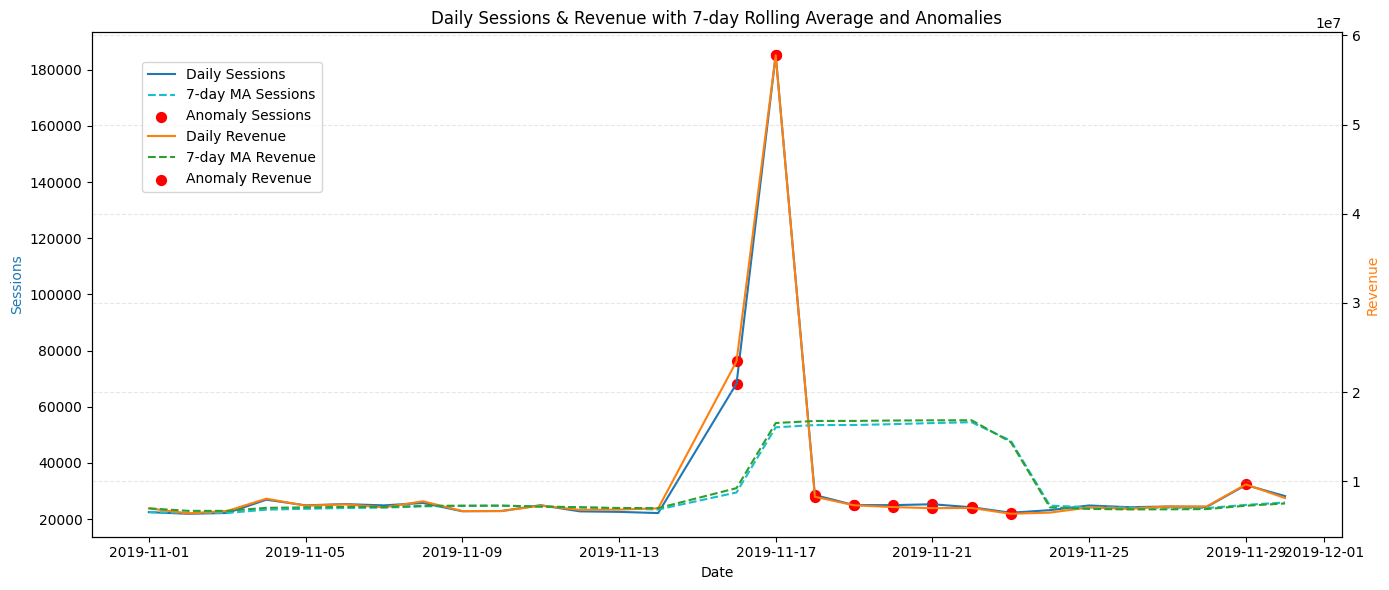

In [9]:
viz = QueryVisualizer(resultDf)
viz.plotDailySessionsRevenueAnomaly()



---

## **Q1 – Implementing RFM Analysis**

**Objective:**
Compute **Recency, Frequency, and Monetary** metrics per customer to quantify engagement and value.

**Analytical Strategy:**

1. **Recency:**

   * Days since last purchase: `CURRENT_DATE - MAX(event_time)` per customer.
2. **Frequency:**

   * Count of purchases per customer.
3. **Monetary:**

   * Total spend per customer.
4. **Use of SQL window functions:**

   * Can calculate percentiles (later used for segmentation).
   * Aggregate metrics per customer using `GROUP BY`.

**Solution Measures:**

* Created a **materialized view** `customer_rfm_summary` for efficiency on 65M records.
* Used **`FILTER` clauses** to count only purchases.
* Handled edge cases like customers with zero purchases or null monetary values.

**Business Interpretation:**

* Provides a **baseline for customer value**.
* Key input for segmentation, marketing campaigns, and retention strategies.

---






In [21]:
query = "select * from customer_rfm"
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 3696117 rows
First row sample: (518514099, 2131.0, 202, Decimal('203986.07'))


C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


shape: (3_696_117, 4)
┌───────────┬─────────┬───────────┬──────────────┐
│ user_id   ┆ recency ┆ frequency ┆ monetary     │
│ ---       ┆ ---     ┆ ---       ┆ ---          │
│ i64       ┆ f64     ┆ i64       ┆ decimal[*,2] │
╞═══════════╪═════════╪═══════════╪══════════════╡
│ 518514099 ┆ 2131.0  ┆ 202       ┆ 203986.07    │
│ 512386086 ┆ 2129.0  ┆ 268       ┆ 161682.49    │
│ 564068124 ┆ 2129.0  ┆ 519       ┆ 131929.20    │
│ 515715331 ┆ 2131.0  ┆ 80        ┆ 117130.12    │
│ 521230795 ┆ 2129.0  ┆ 120       ┆ 111072.35    │
│ …         ┆ …       ┆ …         ┆ …            │
│ 570677590 ┆ null    ┆ 0         ┆ 0.00         │
│ 570677602 ┆ null    ┆ 0         ┆ 0.00         │
│ 570677625 ┆ null    ┆ 0         ┆ 0.00         │
│ 570677627 ┆ null    ┆ 0         ┆ 0.00         │
│ 570677663 ┆ null    ┆ 0         ┆ 0.00         │
└───────────┴─────────┴───────────┴──────────────┘


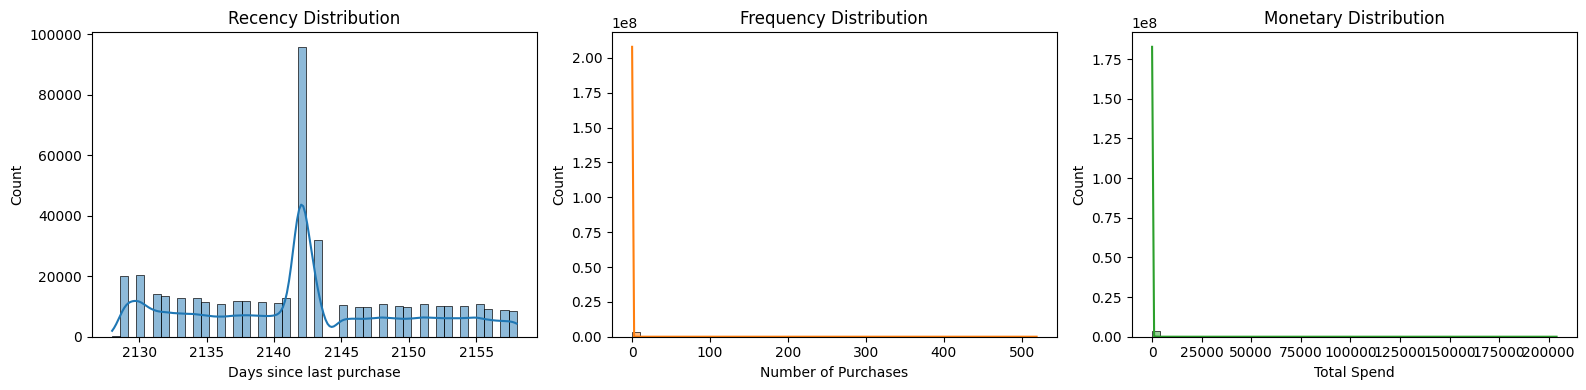

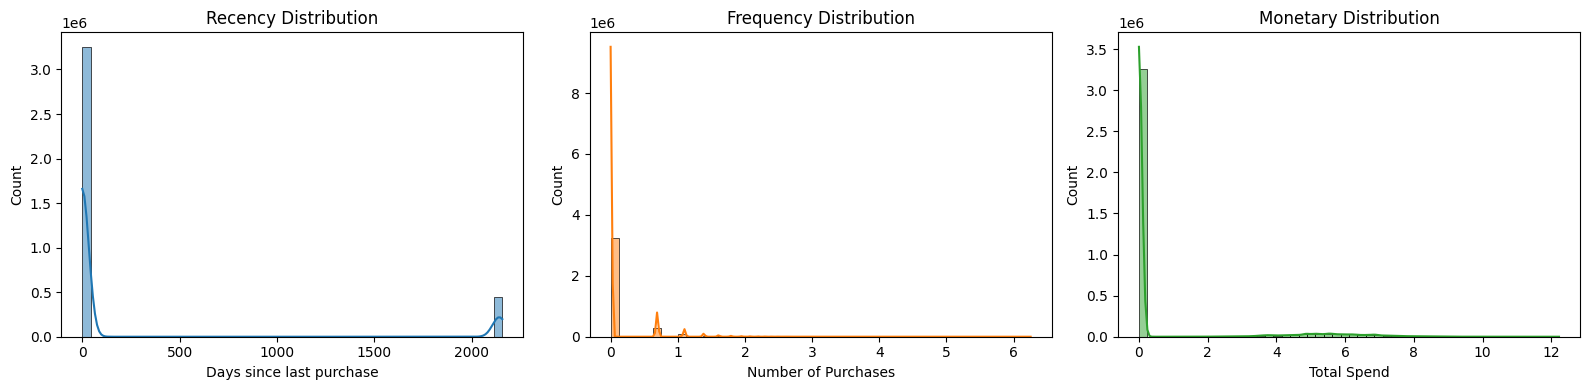

In [ ]:
viz = QueryVisualizer(resultDf)
viz.plotRFMHistograms(log_transform=False)       
viz.plotRFMHistograms(log_transform=True)       


---

## **Q2 – Dynamic Customer Segmentation Based on Percentiles**

**Objective:**
Classify customers into segments (Power Users, Quick Buyers, Browsers/Bots, Disengaged) based on **purchase behavior**.

**Analytical Strategy:**

1. Compute **percentiles** (or numeric thresholds) for RFM metrics.
2. **Define segments using `CASE WHEN`:**

   * Power Users → recent, frequent, high spend
   * Quick Buyers → recent, moderate frequency, moderate spend
   * Browsers/Bots → low frequency & low spend
   * Disengaged → remaining customers
3. **Iterative adjustment:**

   * Initially used percentile thresholds → didn’t work due to skewed data (many zeros).
   * Switched to **numeric thresholds** derived from actual RFM distributions.
4. **Order of `CASE WHEN` matters:**

   * Ensure highest-value segments are matched first.

**Solution Measures:**

* Used **numeric thresholds**: e.g., `frequency > 5 AND monetary >= 500` for Power Users.
* Validated segment distribution to ensure **all four segments exist**.

**Business Interpretation:**

* Identifies **high-value vs low-value customers**.
* Useful for marketing, loyalty programs, promotions, and targeted campaigns.

---

In [10]:
query = """
WITH customer_rfm_with_percentiles as (
SELECT *,
       PERCENT_RANK() OVER (ORDER BY recency ASC) AS recency_percentile,
       PERCENT_RANK() OVER (ORDER BY frequency DESC) AS frequency_percentile,
       PERCENT_RANK() OVER (ORDER BY monetary DESC) AS monetary_percentile
FROM customer_rfm
),
customer_segments AS (
SELECT *,
    CASE
        WHEN frequency > 5
             AND monetary >= 500 THEN 'Power Users'
        WHEN frequency BETWEEN 1 AND 5
             AND monetary >= 100 THEN 'Quick Buyers'
        WHEN frequency = 0
             OR monetary < 100 THEN 'Browsers/Bots'
        ELSE 'Disengaged Users'
    END AS customer_segment
FROM customer_rfm_summary
)
SELECT customer_segment,
       COUNT(*) AS num_users
FROM customer_segments
GROUP BY customer_segment
ORDER BY num_users DESC;
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 4 rows
First row sample: ('Browsers/Bots', 3357105)
shape: (4, 2)
┌──────────────────┬───────────┐
│ customer_segment ┆ num_users │
│ ---              ┆ ---       │
│ str              ┆ i64       │
╞══════════════════╪═══════════╡
│ Browsers/Bots    ┆ 3357105   │
│ Quick Buyers     ┆ 316180    │
│ Power Users      ┆ 21360     │
│ Disengaged Users ┆ 1472      │
└──────────────────┴───────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


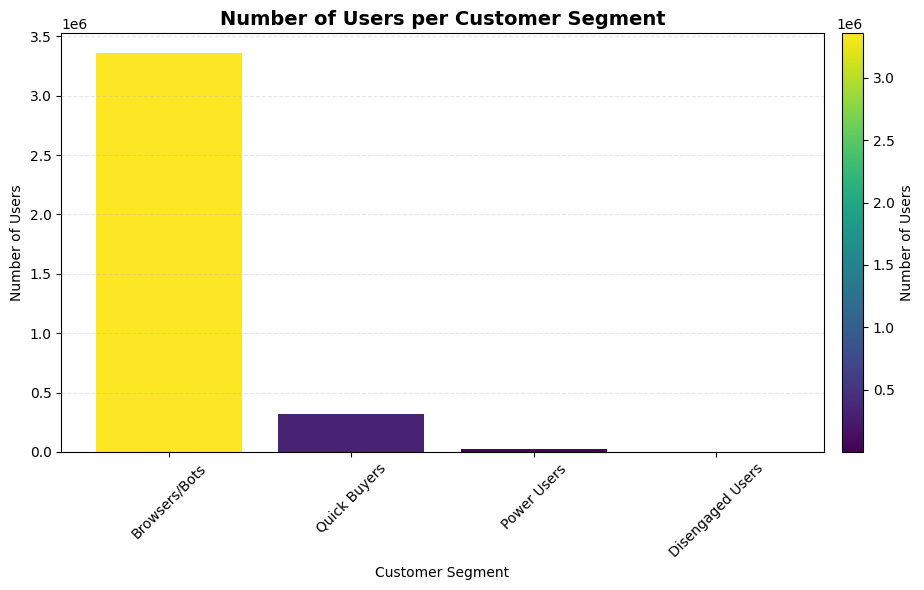

In [20]:
viz = QueryVisualizer(resultDf)
viz.plotCustomerSegmentDistribution()

---

## **Q3 – Customer Churn Probability Using Cohort Analysis**

**Objective:**
Estimate the probability that a customer stops purchasing over time using cohort analysis.

**Analytical Strategy:**

1. Define **cohorts** based on first purchase date.
2. Track **retention over subsequent periods**.
3. Calculate churn probability:

[
\text{Churn Probability} = 1 - \text{Retention Rate}
]

**Measures Taken:**

* With only **one month of data**, true churn cannot be calculated.
* Marked this analysis as **unapplicable**.
* Optional alternative: compute **short-term engagement proxies** (e.g., single vs multiple purchases in the month).

**Business Interpretation:**

* True churn probability requires multi-period data.
* Stakeholders would use it for retention campaigns and revenue forecasting once enough historical data is available.




---

## **Task 3 – Advanced Aggregations & Reporting (Q7–Q9)**

---

### **Q7: Using PIVOT Operations for Category Performance by Month**

**Objective:**
Transform detailed event-level data into a **cross-tab format**, where each row is a category and each column represents a month, showing a metric like revenue or purchase count.

**Analytical Strategy:**

1. **Step 1 – Identify the grouping and measure:**

   * Group by `category_l1` (or `category_l2/l3`).
   * Metric: total purchases, revenue, or session count.
2. **Step 2 – Check time granularity:**

   * Extract month from `event_time`.
   * Must have **multiple months** for pivot to be meaningful.
3. **Step 3 – Use PIVOT / conditional aggregation:**

   * If the SQL dialect supports `PIVOT`, use it.
   * Otherwise, use `CASE WHEN MONTH(event_time) = X THEN metric END` with `SUM()`.
4. **Step 4 – Edge cases:**

   * Categories with zero activity in a month → fill with 0 or NULL.

**Business Interpretation:**

* Quickly see which categories perform best per month.
* Identify seasonal trends and allocate inventory or marketing resources.

**Applicability in our project:**

* **Currently inapplicable** due to having only **one month of data**.





---

### **Q8: Funnel Conversion Rates (View → Cart → Purchase)**

**Objective:**
Calculate the **drop-off between funnel stages** for different segments (e.g., category, RFM group, traffic source).

**Analytical Strategy:**

1. **Step 1 – Aggregate event counts per stage:**

   * Count `view`, `cart`, and `purchase` events per segment (`category_l1`, `brand`, or customer segment).
2. **Step 2 – Calculate conversion rates:**

   * View → Cart: `cart_count / view_count`
   * Cart → Purchase: `purchase_count / cart_count`
   * Full funnel: `purchase_count / view_count`
   * Use `NULLIF()` to avoid division by zero.
3. **Step 3 – Optional segmentation:**

   * By category (`category_l1`) → shows product-level impact.
   * By customer type (RFM segments) → shows behavioral differences.
4. **Step 4 – Business interpretation:**

   * Identify bottlenecks in the funnel.
   * Prioritize interventions for high-impact segments.

**SQL Implementation:**

* We created a CTE `category_seg` that counts events per stage.
* Calculated `vc_conversion_rate`, `cp_conversion_rate`, and `vp_conversion_rate`.
---

In [30]:
query = """
WITH category_seg AS (
    SELECT
        category_l1,
        SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_count,
        SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS view_count,
        SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS cart_count
    FROM 
        ecommerce_events
    GROUP BY
        category_l1
)
SELECT
    category_l1,
    cart_count * 1.0 / NULLIF(view_count, 0)   AS vc_conversion_rate, 
    purchase_count * 1.0 / NULLIF(cart_count, 0) AS cp_conversion_rate, 
    purchase_count * 1.0 / NULLIF(view_count, 0) AS vp_conversion_rate 
FROM
    category_seg
ORDER BY
    vp_conversion_rate DESC;
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 14 rows
First row sample: ('electronics', Decimal('0.06932120658215100177'), Decimal('0.32385740378206171174'), Decimal('0.02245018599073539107'))
shape: (14, 4)
┌──────────────┬────────────────────────┬────────────────────────┬────────────────────────┐
│ category_l1  ┆ vc_conversion_rate     ┆ cp_conversion_rate     ┆ vp_conversion_rate     │
│ ---          ┆ ---                    ┆ ---                    ┆ ---                    │
│ str          ┆ decimal[*,20]          ┆ decimal[*,20]          ┆ decimal[*,20]          │
╞══════════════╪════════════════════════╪════════════════════════╪════════════════════════╡
│ electronics  ┆ 0.06932120658215100177 ┆ 0.32385740378206171174 ┆ 0.02245018599073539107 │
│ medicine     ┆ 0.06135619341167405124 ┆ 0.27001569858712715856 ┆ 0.01656713542670005779 │
│ stationery   ┆ 0.05392279996650757766 ┆ 0.29658385093167701863 ┆ 0.01599263166708532195 │
│ appliances   ┆ 0.04389398829059042197 ┆ 0.28067082555077816104 ┆ 0.012319761930236203

C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


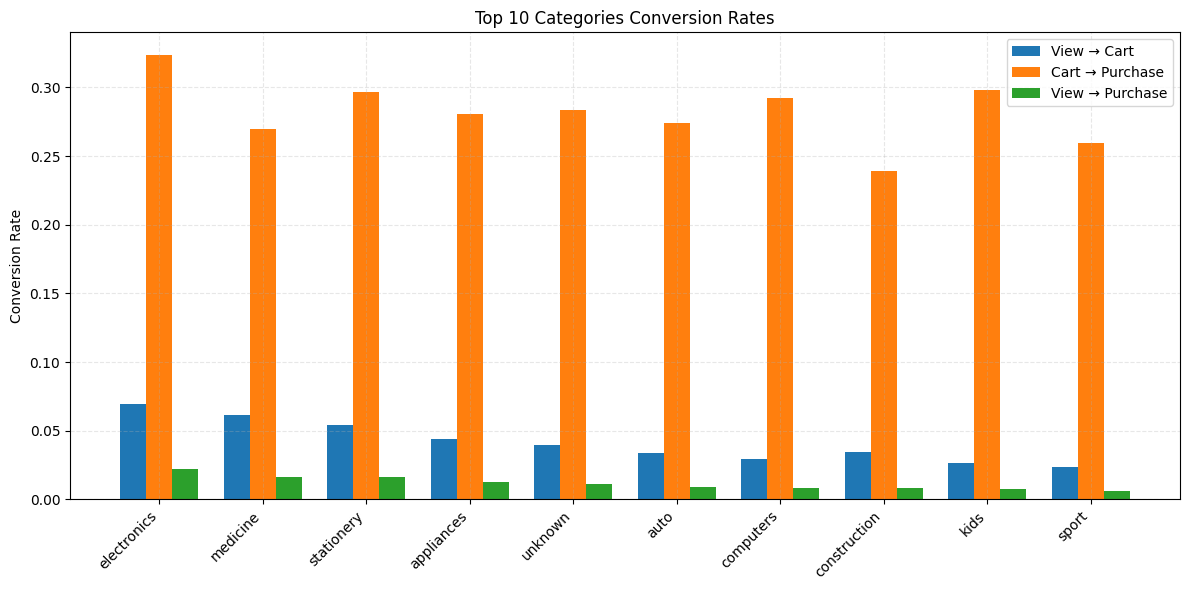

In [33]:
viz = QueryVisualizer(resultDf)
viz.plotCategoryConversionRates(topN=10)

---

### **Q9: Statistical Functions for Product Price Analysis**

**Objective:**
Analyze **price distributions** and **relationships** with engagement metrics to inform pricing and merchandising decisions.

**Analytical Strategy:**

1. **Step 1 – Remove extreme/luxury outliers:**

   * Use `isExtremeOutlier = false` and `isLuxuryItem = false`.
2. **Step 2 – Grouping:**

   * By `category_l1` or `(category_l1, brand)` to capture meaningful subgroups.
3. **Step 3 – Apply statistical functions:**

   * Average price: `AVG(price)`
   * Price variability: `STDDEV(price)`
   * Correlation with engagement metrics:

     * `CORR(price, popularityScore)` → effect of price on product popularity
     * Avoid `CORR(price, categoryConversionRate)` if variance is too low
   * Use `FILTER (WHERE metric IS NOT NULL)` to prevent null issues.
4. **Step 4 – Business interpretation:**

   * Categories with high stddev → mixed pricing, may need segmentation.
   * Strong correlation → pricing affects conversion/popularity.
   * Weak correlation → other factors drive engagement; pricing less sensitive.

**SQL Implementation:**

* Aggregated by category and brand, filtered out outliers.
* Applied `AVG`, `STDDEV`, and `CORR` with proper null handling.

---


In [34]:
query = """
SELECT
    category_l1,
    brand,
    AVG(price) AS price_average,
    STDDEV(price) AS price_std,
    CORR(price, popularityScore) 
        FILTER (WHERE popularityScore IS NOT NULL) AS corr_price_vs_popularity_score
FROM
    ecommerce_events
WHERE
    isExtremeOutlier = false 
    AND isLuxuryItem = false
GROUP BY 
    category_l1, brand
ORDER BY
    category_l1, brand;
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 5468 rows
First row sample: ('accessories', 'a-elita', Decimal('47.9726562500000000'), Decimal('30.9379801304531177'), 0.7459078846803081)
shape: (5_468, 5)
┌─────────────┬────────────────────┬─────────────────────┬────────────────────┬────────────────────┐
│ category_l1 ┆ brand              ┆ price_average       ┆ price_std          ┆ corr_price_vs_popu │
│ ---         ┆ ---                ┆ ---                 ┆ ---                ┆ larity_score       │
│ str         ┆ str                ┆ decimal[*,20]       ┆ decimal[*,24]      ┆ ---                │
│             ┆                    ┆                     ┆                    ┆ f64                │
╞═════════════╪════════════════════╪═════════════════════╪════════════════════╪════════════════════╡
│ accessories ┆ a-elita            ┆ 47.9726562500000000 ┆ 30.937980130453117 ┆ 0.745908           │
│             ┆                    ┆ 0000                ┆ 700000000          ┆                    │
│ accessories ┆ acer

C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


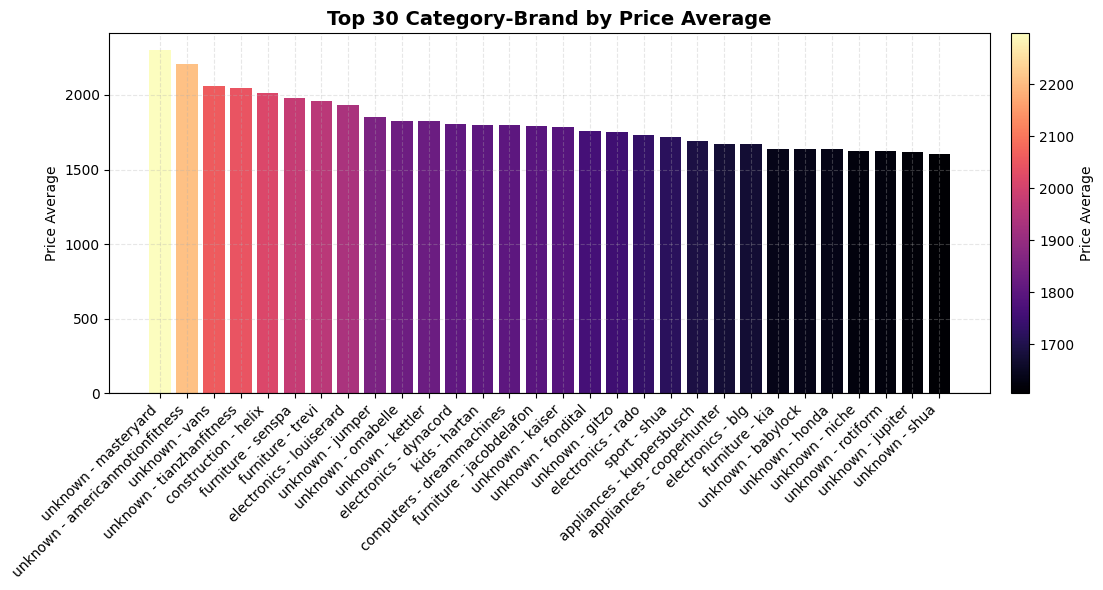

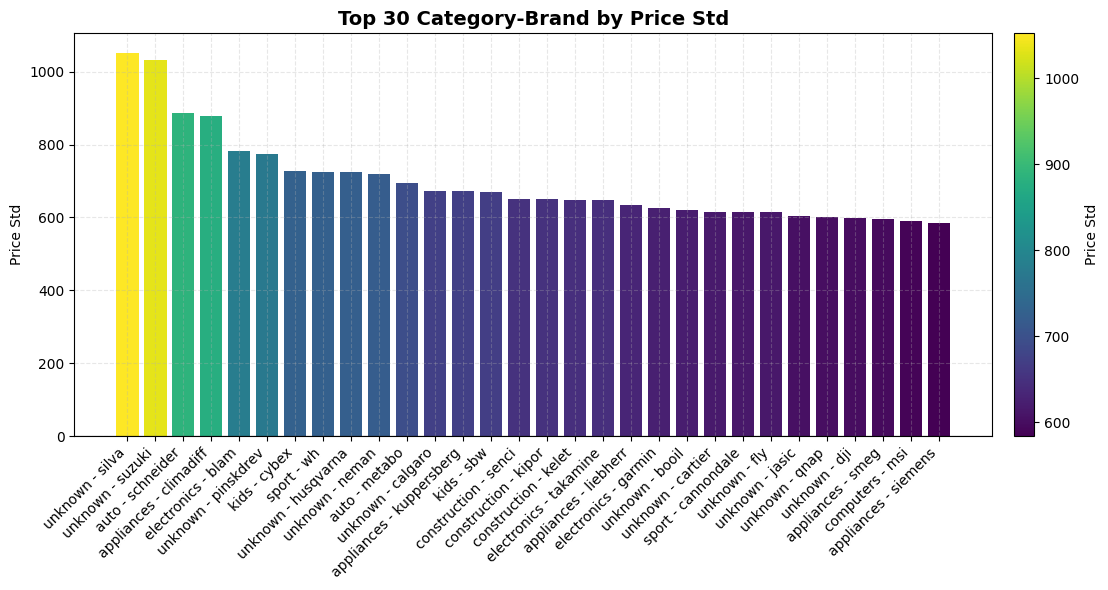

In [58]:
viz = QueryVisualizer(resultDf)
viz.plotCategoryBrandPriceStats(topN=30, metric="price_average", cmap='magma')
viz.plotCategoryBrandPriceStats(topN=30, metric="price_std")


---

## 1 **Fraud Detection Strategy – User/Session-Based Metrics**

**Objective:**
Detect potentially fraudulent activity by analyzing **transaction frequency, revenue, and session behavior** at both user and session levels.

---

### **1. Transaction Frequency per User**

**Metric Calculated:**

* `daily_purchases`: Number of purchases per user per hour (`user_id`, `sessionStartHour`).
* `user_revenue`: Total revenue per user per hour.

**Analytical Strategy:**

1. Aggregate data by user and hour (`user_id`, `sessionStartHour`).
2. Compute the **95th percentile** of purchases and revenue across all users.
3. Flag users who exceed these thresholds as **suspicious**.

**Business Interpretation:**

* Users with unusually high purchase counts or revenue may indicate **fraudulent accounts** or automated purchase attempts.
* Stakeholders can monitor these users for manual review, temporary holds, or further investigation.

---

### **2. Transaction Frequency per Session**

**Metric Calculated:**

* `session_duration_seconds`: Length of each session in seconds (`MAX(event_time) - MIN(event_time)`).
* `purchase_velocity`: Purchases per second in a session.
* `daily_purchases` and `user_revenue` at the session level.

**Analytical Strategy:**

1. Aggregate events by `user_id` and `user_session`.
2. Calculate session duration and derive **purchase velocity**.
3. Compute **95th percentiles** for:

   * `daily_purchases`
   * `user_revenue`
   * `purchase_velocity`
4. Flag sessions exceeding any threshold as suspicious.

**Business Interpretation:**

* High purchase velocity can indicate **bots or automated scripts**.
* Short sessions with multiple purchases or high revenue are potential **high-risk activities**.
* Helps operational teams focus on sessions that deviate from normal behavior.

---

### **3. Flagging Strategy**

* Any user/session exceeding the threshold in **purchases, revenue, or velocity** is flagged:

  * `suspicious_purchase_flag`
  * `suspicious_revenue_flag`
  * `suspicious_velocity_flag`

* Combine flags to get a **composite fraud risk view**:

  * Single flag → moderate risk
  * Multiple flags → high risk

**Outcome:**

* Provides a **layered approach** to detect fraud using multiple behavioral and monetary signals.
* Reduces false positives by considering both **aggregate and session-level anomalies**.

---


In [59]:
query = """
WITH category_seg AS (
    SELECT
        user_id,
        sessionStartHour,
        SUM(price) AS user_revenue,
        COUNT(*) FILTER (WHERE event_type = 'purchase') AS daily_purchases
    FROM ecommerce_events
    GROUP BY user_id, sessionStartHour
),
thresholds AS (
    SELECT
        percentile_cont(0.95) WITHIN GROUP (ORDER BY daily_purchases) AS p95_purchases,
        percentile_cont(0.95) WITHIN GROUP (ORDER BY user_revenue)   AS p95_revenue
    FROM category_seg
),
res AS (
	SELECT
	    c.user_id,
	    c.sessionStartHour,
	    c.daily_purchases,
	    c.user_revenue,
	    CASE WHEN c.daily_purchases > t.p95_purchases THEN 1 ELSE 0 END AS suspicious_purchase_flag,
	    CASE WHEN c.user_revenue > t.p95_revenue     THEN 1 ELSE 0 END AS suspicious_revenue_flag
	FROM category_seg c
	CROSS JOIN thresholds t
)
select * from res where suspicious_purchase_flag = 1 or suspicious_revenue_flag = 1
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 575540 rows
First row sample: (120701478, 21, 0, Decimal('24434.68'), 0, 1)


C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


shape: (575_540, 6)
┌───────────┬─────────────────┬─────────────────┬──────────────┬─────────────────┬─────────────────┐
│ user_id   ┆ sessionstarthou ┆ daily_purchases ┆ user_revenue ┆ suspicious_purc ┆ suspicious_reve │
│ ---       ┆ r               ┆ ---             ┆ ---          ┆ hase_flag       ┆ nue_flag        │
│ i64       ┆ ---             ┆ i64             ┆ decimal[*,2] ┆ ---             ┆ ---             │
│           ┆ i64             ┆                 ┆              ┆ i64             ┆ i64             │
╞═══════════╪═════════════════╪═════════════════╪══════════════╪═════════════════╪═════════════════╡
│ 120701478 ┆ 21              ┆ 0               ┆ 24434.68     ┆ 0               ┆ 1               │
│ 128968633 ┆ 16              ┆ 0               ┆ 10345.07     ┆ 0               ┆ 1               │
│ 226315556 ┆ 13              ┆ 0               ┆ 14240.55     ┆ 0               ┆ 1               │
│ 242946651 ┆ 20              ┆ 0               ┆ 20603.30     ┆ 0     

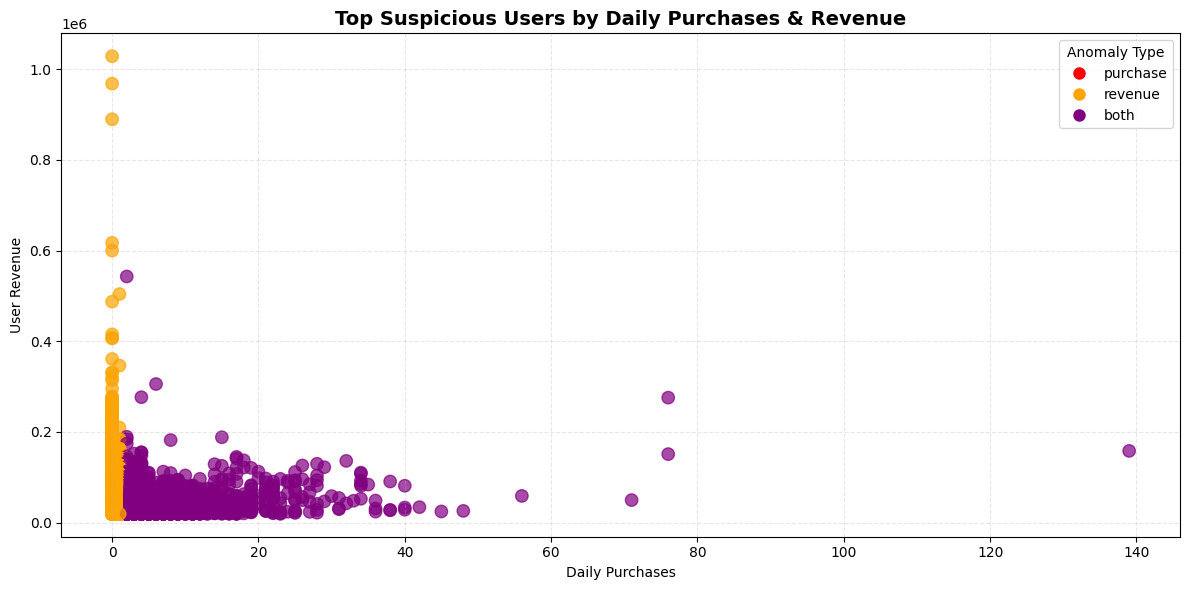

In [65]:
viz = QueryVisualizer(resultDf)
viz.plotSuspiciousUsers(topN=100000)

In [66]:
query = """
WITH category_seg AS (
    SELECT
        user_id,
        user_session,
        MIN(event_time) AS session_start,
        MAX(event_time) AS session_end,
        SUM(price) AS user_revenue,
        COUNT(*) FILTER (WHERE event_type = 'purchase') AS daily_purchases
    FROM ecommerce_events
    GROUP BY user_id, user_session
),
session_metrics AS (
    SELECT
        user_id,
        user_session,
        user_revenue,
        daily_purchases,
        EXTRACT(EPOCH FROM (session_end - session_start)) AS session_duration_seconds
    FROM category_seg
),
thresholds AS (
    SELECT
        percentile_cont(0.95) WITHIN GROUP (ORDER BY daily_purchases) AS p95_purchases,
        percentile_cont(0.95) WITHIN GROUP (ORDER BY user_revenue)   AS p95_revenue,
        percentile_cont(0.95) WITHIN GROUP (ORDER BY 
            (daily_purchases::float / NULLIF(session_duration_seconds,0))
        ) AS p95_purchase_velocity
    FROM session_metrics
),
res AS (
	SELECT
	    c.user_id,
	    c.user_session,
	    c.daily_purchases,
	    c.user_revenue,
	    c.session_duration_seconds,
	    (c.daily_purchases::float / NULLIF(c.session_duration_seconds,0)) AS purchase_velocity,
	    CASE WHEN c.daily_purchases > t.p95_purchases THEN 1 ELSE 0 END AS suspicious_purchase_flag,
	    CASE WHEN c.user_revenue > t.p95_revenue THEN 1 ELSE 0 END AS suspicious_revenue_flag,
	    CASE WHEN (c.daily_purchases::float / NULLIF(c.session_duration_seconds,0)) > t.p95_purchase_velocity 
	         THEN 1 ELSE 0 END AS suspicious_velocity_flag
	FROM session_metrics c
	CROSS JOIN thresholds t
)
SELECT * 
FROM res 
WHERE suspicious_purchase_flag = 1 
   OR suspicious_revenue_flag = 1 
   OR suspicious_velocity_flag = 1;
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 1129045 rows
First row sample: (120701478, '69f75110-556e-4a46-88eb-b62d347df229', 0, Decimal('24434.68'), Decimal('1103592.000000'), 0.0, 0, 1, 0)


C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


shape: (1_129_045, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ user_id   ┆ user_sess ┆ daily_pur ┆ user_reve ┆ … ┆ purchase_ ┆ suspiciou ┆ suspiciou ┆ suspicio │
│ ---       ┆ ion       ┆ chases    ┆ nue       ┆   ┆ velocity  ┆ s_purchas ┆ s_revenue ┆ us_veloc │
│ i64       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e_flag    ┆ _flag     ┆ ity_flag │
│           ┆ str       ┆ i64       ┆ decimal[* ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆ ,2]       ┆   ┆           ┆ i64       ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 120701478 ┆ 69f75110- ┆ 0         ┆ 24434.68  ┆ … ┆ 0.0       ┆ 0         ┆ 1         ┆ 0        │
│           ┆ 556e-4a46 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ -88eb-b62 ┆           ┆           ┆   ┆           ┆    

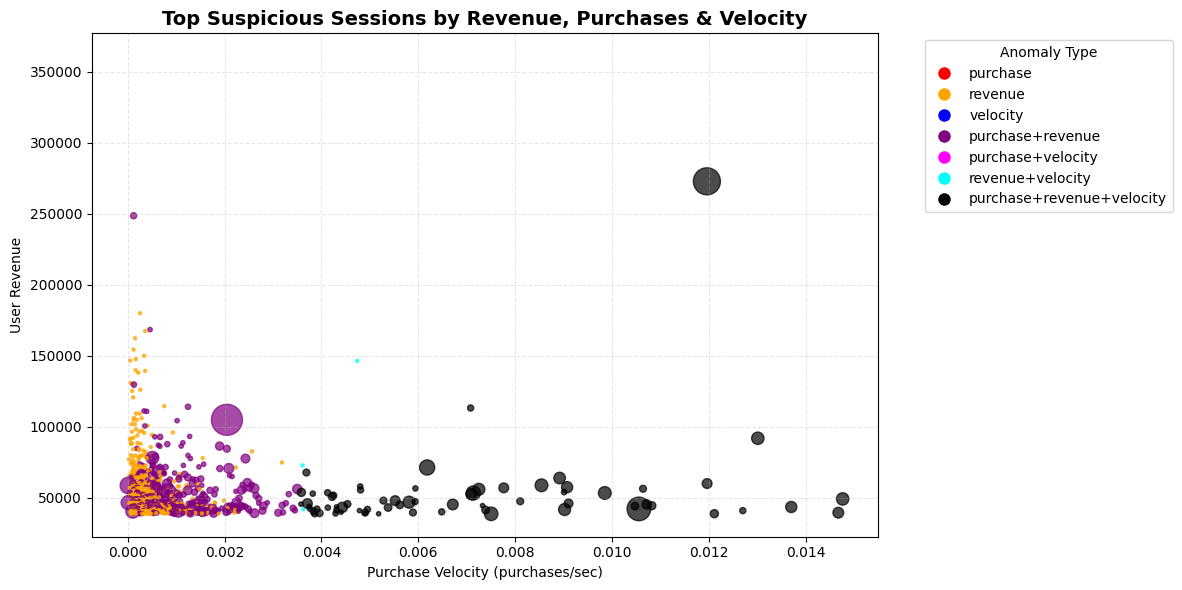

In [72]:
viz = QueryVisualizer(resultDf)
viz.plotSuspiciousSessions(topN=10000)


---

## **2. Inventory Turnover & Reorder Points (SQL Analytics)**

**Applicability:**  Currently **inapplicable** with your dataset because inventory levels and supplier lead times are not included.

**Analytical Strategy (if full inventory data were available):**

1. **Metrics to calculate:**

   * **Units Sold** per product over a period (e.g., month).

   * **Average Inventory**: (Starting inventory + Ending inventory)/2.

   * **Inventory Turnover Rate**:

     $$
     \text{Inventory Turnover} = \frac{\text{Units Sold}}{\text{Average Inventory}}
     $$

   * **Reorder Point (ROP):**

     $$
     \text{ROP} = \text{Average Daily Usage} \times \text{Lead Time} + \text{Safety Stock}
     $$

2. **Edge Cases & Considerations:**

   * Avoid division by zero for products with no inventory.
   * Handle seasonal or low-frequency products with adjusted averages.

3. **Business Interpretation:**

   * High turnover → fast-selling products; low turnover → potential overstock.
   * ROP helps automate procurement and prevent stockouts.

4. **SQL Approach (if data available):**

   * Aggregate sales per product using `SUM(quantity)` or `COUNT(*)`.
   * Join with inventory snapshots for turnover.
   * Use rolling averages or window functions for daily usage calculations.

---

## **3. Real-Time Dashboard Metrics**

**Applicability:**  Can be applied with your historical dataset to simulate real-time dashboards.

**Analytical Strategy:**

1. **Define Metrics:**

   * Sales: total revenue, purchases.
   * User activity: active sessions, conversions.
   * Product performance: top-selling categories or items.

2. **Choose Time Windows:**

   * Sliding windows (last hour, day, week) using `event_time`.
   * For historical data, simulate “real-time” by picking a day/week subset.

3. **Aggregate & Compute KPIs:**

   * Use `COUNT`, `SUM`, `AVG` for core metrics.
   * Use window functions for rolling metrics or trends.
   * Calculate derived metrics like conversion rates: `cart → purchase`, `view → cart`.

4. **Optimize for Performance:**

   * Consider materialized views or pre-aggregated tables for large datasets.
   * Index `event_time`, `user_id`, and `product_id` to speed queries.

5. **Business Interpretation:**

   * Enables stakeholders to monitor KPIs and react quickly to trends.
   * Helps identify high-performing products, active customer segments, and potential issues.

6. **SQL Structure Example (approach, not code):**

   * **Step 1:** Filter `event_time` for the desired window.
   * **Step 2:** Aggregate metrics by category/product/user segment.
   * **Step 3:** Compute derived KPIs (conversion rates, revenue share).
   * **Step 4:** Order or rank metrics for dashboard display.

---




In [73]:
query = """
WITH recent_events AS (
    -- Filter events within November 2019
    SELECT *
    FROM ecommerce_events
    WHERE event_time >= '2019-11-01' 
      AND event_time < '2019-12-01'
),

aggregated_metrics AS (
    -- Compute core metrics per category or product
    SELECT
        category_l1,
        COUNT(*) FILTER (WHERE event_type = 'view') AS views_nov,
        COUNT(*) FILTER (WHERE event_type = 'cart') AS carts_nov,
        COUNT(*) FILTER (WHERE event_type = 'purchase') AS purchases_nov,
        SUM(price) FILTER (WHERE event_type = 'purchase') AS revenue_nov
    FROM recent_events
    GROUP BY category_l1
),

conversion_rates AS (
    -- Compute conversion rates
    SELECT
        category_l1,
        views_nov,
        carts_nov,
        purchases_nov,
        revenue_nov,
        CASE WHEN views_nov > 0 THEN carts_nov * 1.0 / views_nov ELSE 0 END AS view_to_cart_rate,
        CASE WHEN carts_nov > 0 THEN purchases_nov * 1.0 / carts_nov ELSE 0 END AS cart_to_purchase_rate
    FROM aggregated_metrics
)

SELECT *
FROM conversion_rates
ORDER BY revenue_nov DESC;
"""
resultDf = dataSqlIntegration.answerQueryAnswer(connection=connection, queryString=query)
print(resultDf)

Query returned 14 rows
First row sample: ('electronics', 21988192, 1524248, 493639, Decimal('205250118.21'), Decimal('0.06932120658215100177'), Decimal('0.32385740378206171174'))
shape: (14, 7)
┌──────────────┬───────────┬───────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ category_l1  ┆ views_nov ┆ carts_nov ┆ purchases_no ┆ revenue_nov  ┆ view_to_cart ┆ cart_to_purc │
│ ---          ┆ ---       ┆ ---       ┆ v            ┆ ---          ┆ _rate        ┆ hase_rate    │
│ str          ┆ i64       ┆ i64       ┆ ---          ┆ decimal[*,2] ┆ ---          ┆ ---          │
│              ┆           ┆           ┆ i64          ┆              ┆ decimal[*,20 ┆ decimal[*,20 │
│              ┆           ┆           ┆              ┆              ┆ ]            ┆ ]            │
╞══════════════╪═══════════╪═══════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ electronics  ┆ 21988192  ┆ 1524248   ┆ 493639       ┆ 205250118.21 ┆ 0.0693212065 ┆ 0.3238574037 

C:\Users\negam\AppData\Local\Temp\ipykernel_23316\2175917249.py:244: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(queryRows, schema=col_names)


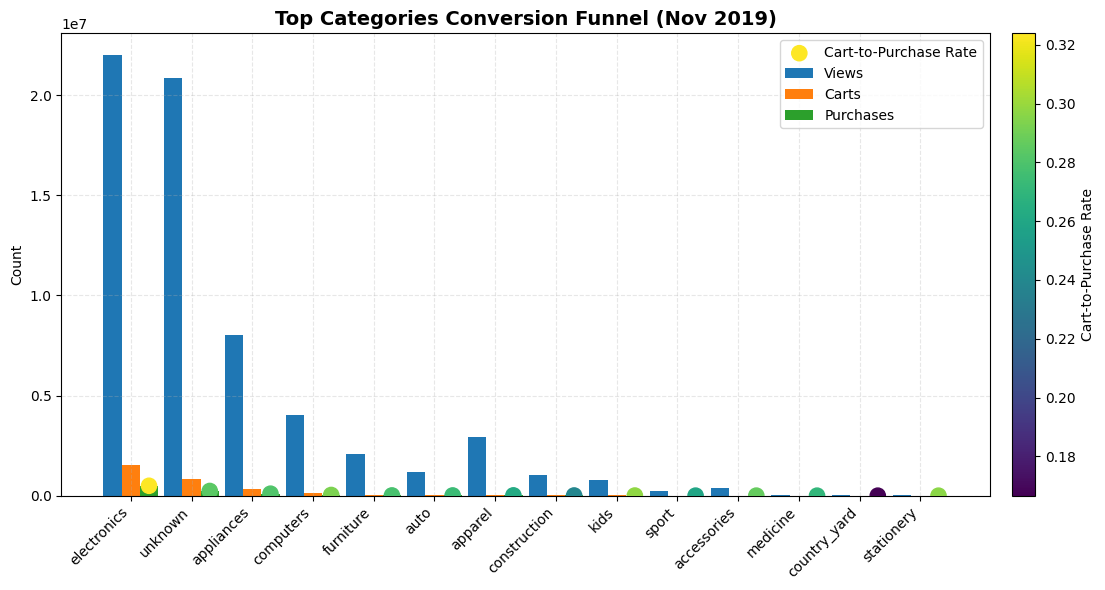

In [77]:
viz = QueryVisualizer(resultDf)
viz.plotCategoryConversionFunnel()